# Kaggle GI Tract Train

Using code snippets from:
https://www.kaggle.com/code/yiheng/3d-solution-with-monai-produce-3d-data/notebook
https://www.kaggle.com/code/israrahmed919/createmasksopencv
https://www.kaggle.com/code/clemchris/gi-seg-pytorch-train-infer


Consider:
https://github.com/catalyst-team/catalyst - training loop - was buggy so abandoned the idea.

https://torchio.readthedocs.io/data/image.html - has simulation of intensity artifacts due to MRI magnetic field inhomogeneity (bias) or k-space motion artifacts.


https://www.kaggle.com/code/yiheng/50-times-faster-way-get-hausdorff-with-monai 



**Notes**
* create simple model for first submission - done
* Add some augmentation transforms (https://github.com/albumentations-team/albumentations)
    * rotation (10 deg)
    * resize
* Extend training epochs

* remove bad data https://www.kaggle.com/competitions/uw-madison-gi-tract-image-segmentation/discussion/321979



* Go to 2.5 D method

* Go to 3D method




* add Hausdorff metric https://github.com/mavillan/py-hausdorff
https://www.kaggle.com/code/carnozhao/tract-competiton-metrics



In [1]:
import os, glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from einops import rearrange, reduce, repeat

from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold

from pathlib import Path

#import albumentations as A
from torchvision import transforms


#DATASET_FOLDER = "/kaggle/input/uw-madison-gi-tract-image-segmentation"
DATASET_FOLDER = Path("/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation")
TRAIN_FOLDER = DATASET_FOLDER/"train"

MODEL_FOLDER = DATASET_FOLDER/"kaggle models"
os.makedirs(MODEL_FOLDER, exist_ok=True)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#DEVICE = "cpu"
#DEVICE = "cuda:0"

model_name_base = "Unet-3"

# Data

## Process the Metadata

In [2]:
df2d = pd.read_csv(DATASET_FOLDER/"df2d_metadata.csv")
display(df2d.head())

,Unnamed: 0,large_bowel,small_bowel,stomach,id,case_id_str,case_id,day_num_str,day_num,slice_id,...,match,subpath,filename,im_height,im_width,im_pixel_height,im_pixel_width,slice_thickness,segmentations,fold
0,0,NaN,NaN,NaN,case101_day20_slice_0001,case101,101,day20,20,slice_0001,...,case101/case101_day20/scans/slice_0001,case101/case101_day20/scans/slice_0001_266_266...,slice_0001_266_266_1.50_1.50.png,266,266,1.5,1.5,3.0,False,4.0
1,1,NaN,NaN,NaN,case101_day20_slice_0002,case101,101,day20,20,slice_0002,...,case101/case101_day20/scans/slice_0002,case101/case101_day20/scans/slice_0002_266_266...,slice_0002_266_266_1.50_1.50.png,266,266,1.5,1.5,3.0,False,4.0
2,2,NaN,NaN,NaN,case101_day20_slice_0003,case101,101,day20,20,slice_0003,...,case101/case101_day20/scans/slice_0003,case101/case101_day20/scans/slice_0003_266_266...,slice_0003_266_266_1.50_1.50.png,266,266,1.5,1.5,3.0,False,4.0
3,3,NaN,NaN,NaN,case101_day20_slice_0004,case101,101,day20,20,slice_0004,...,case101/case101_day20/scans/slice_0004,case101/case101_day20/scans/slice_0004_266_266...,slice_0004_266_266_1.50_1.50.png,266,266,1.5,1.5,3.0,False,4.0
4,4,NaN,NaN,NaN,case101_day20_slice_0005,case101,101,day20,20,slice_0005,...,case101/case101_day20/scans/slice_0005,case101/case101_day20/scans/slice_0005_266_266...,slice_0005_266_266_1.50_1.50.png,266,266,1.5,1.5,3.0,False,4.0


## Create a Pytorch Dataset

In [3]:
from torchvision.transforms import PILToTensor

In [4]:
class Dataset_from_df(torch.utils.data.Dataset):
    def __init__(self, df, path, joint_transform=None, image_transform=None, mask_transform=None):
        self.df = df
        self.path = path
        self.joint_transform = joint_transform
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.pil_to_tensor = PILToTensor()

        
    def __len__(self):
        return self.df.shape[0]
    
    #Helper Function to decode RLE
    def _rle_decode_float(self,mask_rle, shape, color_val=1):
        '''
        mask_rle: run-length as string formated (start length)
        shape: (height,width) of array to return 
        Returns numpy array, color_val - mask, 0 - background

        '''
        s = mask_rle.split()
        starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
        starts -= 1
        ends = starts + lengths
        #img = np.zeros((shape[0] * shape[1], shape[2]), dtype=np.float32)

        img = torch.zeros(shape[1]*shape[2])
        for lo, hi in zip(starts, ends):
            img[lo : hi] = color_val
        return img.reshape(shape)    
    
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        
        img_path = self.path/row.subpath
        # Use PIL Image to read the image files since it handles 32 bit images
        img = self.pil_to_tensor(Image.open(img_path))
        #print(img.shape)
        
        lb_class_seg = row.large_bowel
        sb_class_seg = row.small_bowel
        st_class_seg = row.stomach
        
        
        mask = torch.zeros((3, img.shape[1], img.shape[2]))

        if type(lb_class_seg) is str:
            mask[0,:,:] = self._rle_decode_float(lb_class_seg,img.shape,color_val=1)

        if type(sb_class_seg) is str:
            mask[1,:,:] = self._rle_decode_float(sb_class_seg, img.shape,color_val=1)

        if type(st_class_seg) is str:
            mask[2,:,:] = self._rle_decode_float(st_class_seg, img.shape,color_val=1)
        
        if self.image_transform:
            img = self.image_transform(img)
            
        if self.mask_transform:
            mask = self.mask_transform(mask)       
        
        if self.joint_transform:            
            image_stack = torch.cat([img, mask], dim=0)
            image_stack = self.joint_transform(image_stack)
            img = image_stack[0:1]
            mask = image_stack[1:4]
        

    
        
        return {
            "image": img,
            "mask": mask,
        }
        
        
    
    


In [5]:
dataset = Dataset_from_df(df2d[df2d['segmentations']],TRAIN_FOLDER)

In [6]:
dataset[665]['image'].max()

tensor(10672, dtype=torch.int32)

In [7]:
def plot_data(d):
    ratio = 1.0
    plt.figure(figsize=(20,20))
    plt.subplot(1,2,1)
    plt.imshow(d['image'].squeeze().numpy(),cmap='gray', aspect=ratio)
    plt.title(f"Image Shape= {d['image'].shape}")
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(rearrange(d['mask'].numpy(),'c h w -> h w c'), aspect=ratio)
    plt.title(f"Mask Shape = {d['mask'].shape}")
    plt.axis('off')

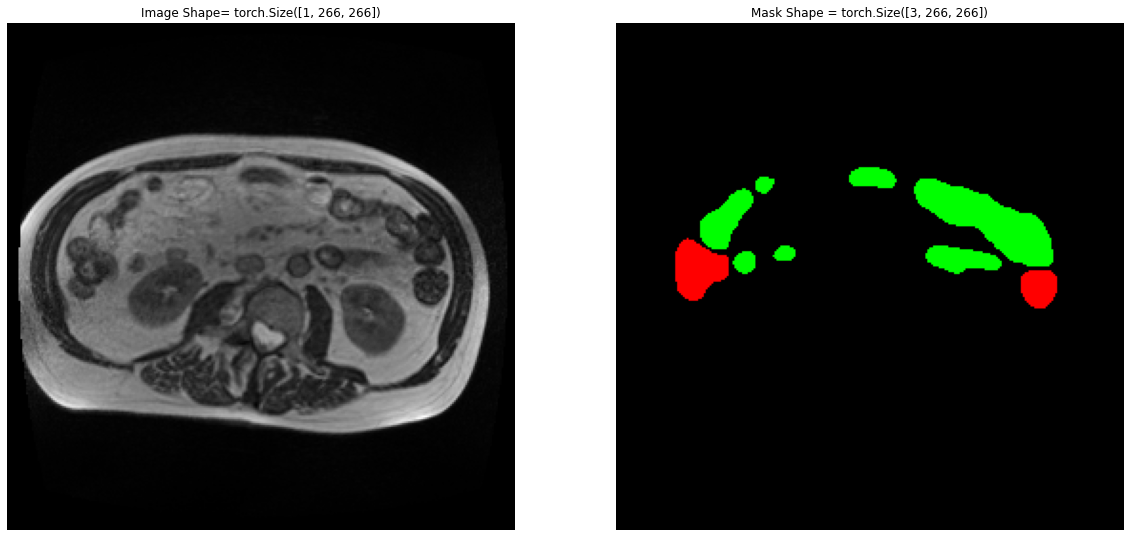

In [8]:
plot_data(dataset[665])

### With n fold cross validation we need a dataset for each fold

In [9]:
def prepare_datasets(df, fold, train_transforms, scale_transforms):
    train_df = df.query("fold!=@fold").reset_index(drop=True)
    valid_df = df.query("fold==@fold").reset_index(drop=True)

    train_dataset = Dataset_from_df(train_df,TRAIN_FOLDER, joint_transform=train_transforms,
                                   image_transform=scale_transforms, mask_transform=scale_transforms)
    valid_dataset = Dataset_from_df(valid_df,TRAIN_FOLDER, joint_transform=None,
                                   image_transform=scale_transforms, mask_transform=scale_transforms)
    
    return train_dataset, valid_dataset

# Training

In [10]:
import segmentation_models_pytorch as smp
from tqdm.notebook import tqdm

## Loss Functions and Metrics

In [11]:
JaccardLoss = smp.losses.JaccardLoss(mode='multilabel')
DiceLoss    = smp.losses.DiceLoss(mode='multilabel')
BCELoss     = smp.losses.SoftBCEWithLogitsLoss()
LovaszLoss  = smp.losses.LovaszLoss(mode='multilabel', per_image=False)
TverskyLoss = smp.losses.TverskyLoss(mode='multilabel', log_loss=False)

def dice_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon)).mean(dim=(1,0))
    return dice

def iou_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    union = (y_true + y_pred - y_true*y_pred).sum(dim=dim)
    iou = ((inter+epsilon)/(union+epsilon)).mean(dim=(1,0))
    return iou

def criterion(y_pred, y_true):
    return 0.5*BCELoss(y_pred, y_true) + 0.5*TverskyLoss(y_pred, y_true)

## Training Loops

In [12]:
def trainfp32(epoch, train_dataloader, optimizer, loss_fn, lr_scheduler,
              metric_fn, model):


    model.train()

    training_loss = 0
    metric = 0

    pbar = tqdm(total=len(train_dataloader))

    for batch in train_dataloader:

        optimizer.zero_grad()

        images, masks = batch['image'], batch['mask']

        images = images.cuda(non_blocking=True)
        masks = masks.cuda(non_blocking=True)

        #print(images.shape, masks.shape)
        
        output = model(images)

        loss = loss_fn(output, masks)


        loss.backward()

        optimizer.step()

        lr_scheduler.step()

        with torch.no_grad():
            training_loss += loss.data.item() * images.size(0)
            y_pred = torch.nn.Sigmoid()(output)
            metric += metric_fn(masks,y_pred) * images.size(0)

        pbar.update(1)
    pbar.close()
    torch.cuda.empty_cache()
    training_loss /= len(train_dataloader.dataset)
    metric /= len(train_dataloader.dataset)
    return training_loss, metric

In [25]:
def validatefp32(valid_dataloader, loss_fn, metric_fn, model):
    validation_loss = 0
    metric = 0
    model.eval()
    pbar = tqdm(total=len(valid_dataloader))
    for batch in valid_dataloader:
        images, masks = batch['image'], batch['mask']

        images = images.cuda(non_blocking=True)
        masks = masks.cuda(non_blocking=True)

        
        with torch.no_grad():
            output = model(images)
            loss = loss_fn(output,masks)
            validation_loss += loss.data.item() * images.size(0)
            y_pred = torch.nn.Sigmoid()(output)
            metric += metric_fn(masks,y_pred) * images.size(0)
        pbar.update(1)
    pbar.close()
    torch.cuda.empty_cache()
    validation_loss /= len(valid_dataloader.dataset)
    metric /= len(valid_dataloader.dataset)
    return validation_loss, metric

## Training

In [14]:
class Squarepad(object):
    """Pad the image in a sample to a given size.

    Args:
        output_size (int): Desired output size.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, image):
        
        #print("s",image.size())
        image_size = image.shape[-2::]
        #print("e",image_size)
        p_left, p_top = [(self.output_size - s) // 2 for s in image_size]
        p_right, p_bottom = [self.output_size - (s+pad) for s, pad in zip(image_size, [p_left, p_top])]
        padding = (p_left, p_top, p_right, p_bottom)
        return transforms.functional.pad(image, padding, 0, 'constant')        
        


In [15]:
squarepad_transform = Squarepad(360)  #max image size is 360x310

In [16]:
train_transforms = transforms.Compose(
    [transforms.RandomRotation(4, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.RandomPerspective(distortion_scale=.2, p=0.5, interpolation=transforms.InterpolationMode.BILINEAR),
    
    ])

In [17]:
scale_transforms = transforms.Compose(
    [squarepad_transform,
    transforms.ConvertImageDtype(torch.float32),
    transforms.Resize((320,320),interpolation=transforms.InterpolationMode.BICUBIC),
    ])  # multiple of 32 for UUnet

### Training

In [18]:
init_lr = .001
epochs = 20
loss_fn = criterion
metric_fn = dice_coef
n_folds = int(df2d['fold'].max()) + 1

In [19]:
for fold in range(0,n_folds):
    
    model = smp.Unet(
    encoder_name="efficientnet-b0",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=3)                    # model output channels (number of classes in your dataset)
    model.cuda()


    
    train_dataset, valid_dataset = prepare_datasets(df2d, fold, train_transforms, scale_transforms)
    
    train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                                   batch_size=8,
                                                   num_workers=10,
                                                   pin_memory=True,
                                                   shuffle=True)

    valid_dataloader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                                   batch_size=8,
                                                   num_workers=10,
                                                   pin_memory=True,
                                                   shuffle=True)
    
    
    
    optimizer = torch.optim.Adam(model.parameters(), lr=init_lr,weight_decay = 1e-6)
    lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=init_lr, steps_per_epoch=len(train_dataloader),
                                                  epochs=epochs)
    
    
    best_validation_loss = 999
    
    
    for epoch in range(1, epochs + 1):

        #lr = lr_scheduler.get_last_lr()
        lr = optimizer.param_groups[0]['lr']
        #print('Fold: {}, Epoch: {}, LR: {:.3e}'.format(fold, epoch, lr[0]), end="--")
        print('Fold: {}, Epoch: {}, LR: {:.3e}'.format(fold, epoch, lr), end="--")

        training_loss, training_metric = trainfp32(epoch,
                                                   train_dataloader,
                                                   optimizer,
                                                   loss_fn,
                                                   lr_scheduler,
                                                   metric_fn,
                                                   model)

        print('Training-- Loss: {:.4f}, Metric: {:.3f}'.format(
            training_loss, training_metric),
              end=',')
        validation_loss, validation_metric = validatefp32(valid_dataloader,
                                                          loss_fn,
                                                          metric_fn,
                                                          model)

        #if validation_loss < best_validation_loss:
            #model_out_str = str(model_out_path/(model_name_base+"_best.pth"))
            #torch.save(model.state_dict(), model_out_str)

        print('Validation-- Loss: {:.4f}, Metric = {:.3f}'.format(
            validation_loss, validation_metric))
        
    model_out_str = str(MODEL_FOLDER/("fold-" + str(fold) + '-' + model_name_base + "-1.pth"))
    print(model_out_str)
    torch.save(model.state_dict(), model_out_str)

Fold: 0, Epoch: 1, LR: 4.000e-05--

  0%|          | 0/3704 [00:00<?, ?it/s]

Training-- Loss: 0.4224, Metric: 0.496,

  0%|          | 0/1108 [00:00<?, ?it/s]

Validation-- Loss: 0.7809, Metric = 0.256
Fold: 0, Epoch: 2, LR: 1.043e-04--

  0%|          | 0/3704 [00:00<?, ?it/s]

Training-- Loss: 0.1995, Metric: 0.805,

  0%|          | 0/1108 [00:00<?, ?it/s]

Validation-- Loss: 0.5295, Metric = 0.692
Fold: 0, Epoch: 3, LR: 2.800e-04--

  0%|          | 0/3704 [00:00<?, ?it/s]

Training-- Loss: 0.1737, Metric: 0.825,

  0%|          | 0/1108 [00:00<?, ?it/s]

Validation-- Loss: 0.6192, Metric = 0.692
Fold: 0, Epoch: 4, LR: 5.200e-04--

  0%|          | 0/3704 [00:00<?, ?it/s]

Training-- Loss: 0.1617, Metric: 0.834,

  0%|          | 0/1108 [00:00<?, ?it/s]

Validation-- Loss: 0.5276, Metric = 0.692
Fold: 0, Epoch: 5, LR: 7.600e-04--

  0%|          | 0/3704 [00:00<?, ?it/s]

Training-- Loss: 0.1541, Metric: 0.841,

  0%|          | 0/1108 [00:00<?, ?it/s]

Validation-- Loss: 0.5098, Metric = 0.487
Fold: 0, Epoch: 6, LR: 9.357e-04--

  0%|          | 0/3704 [00:00<?, ?it/s]

Training-- Loss: 0.1406, Metric: 0.856,

  0%|          | 0/1108 [00:00<?, ?it/s]

Validation-- Loss: 0.5121, Metric = 0.692
Fold: 0, Epoch: 7, LR: 1.000e-03--

  0%|          | 0/3704 [00:00<?, ?it/s]

Training-- Loss: 0.1289, Metric: 0.869,

  0%|          | 0/1108 [00:00<?, ?it/s]

Validation-- Loss: 1.3019, Metric = 0.197
Fold: 0, Epoch: 8, LR: 9.875e-04--

  0%|          | 0/3704 [00:00<?, ?it/s]

Training-- Loss: 0.1207, Metric: 0.879,

  0%|          | 0/1108 [00:00<?, ?it/s]

Validation-- Loss: 0.5274, Metric = 0.692
Fold: 0, Epoch: 9, LR: 9.505e-04--

  0%|          | 0/3704 [00:00<?, ?it/s]

Training-- Loss: 0.1091, Metric: 0.893,

  0%|          | 0/1108 [00:00<?, ?it/s]

Validation-- Loss: 0.5347, Metric = 0.692
Fold: 0, Epoch: 10, LR: 8.909e-04--

  0%|          | 0/3704 [00:00<?, ?it/s]

Training-- Loss: 0.1052, Metric: 0.901,

  0%|          | 0/1108 [00:00<?, ?it/s]

Validation-- Loss: 0.5148, Metric = 0.692
Fold: 0, Epoch: 11, LR: 8.117e-04--

  0%|          | 0/3704 [00:00<?, ?it/s]

Training-- Loss: 0.0996, Metric: 0.904,

  0%|          | 0/1108 [00:00<?, ?it/s]

Validation-- Loss: 0.5460, Metric = 0.692
Fold: 0, Epoch: 12, LR: 7.169e-04--

  0%|          | 0/3704 [00:00<?, ?it/s]

Training-- Loss: 0.0930, Metric: 0.913,

  0%|          | 0/1108 [00:00<?, ?it/s]

Validation-- Loss: 0.5163, Metric = 0.692
Fold: 0, Epoch: 13, LR: 6.112e-04--

  0%|          | 0/3704 [00:00<?, ?it/s]

Training-- Loss: 0.0864, Metric: 0.921,

  0%|          | 0/1108 [00:00<?, ?it/s]

Validation-- Loss: 0.5295, Metric = 0.692
Fold: 0, Epoch: 14, LR: 5.000e-04--

  0%|          | 0/3704 [00:00<?, ?it/s]

Training-- Loss: 0.0821, Metric: 0.923,

  0%|          | 0/1108 [00:00<?, ?it/s]

Validation-- Loss: 0.5220, Metric = 0.692
Fold: 0, Epoch: 15, LR: 3.887e-04--

  0%|          | 0/3704 [00:00<?, ?it/s]

Training-- Loss: 0.0781, Metric: 0.931,

  0%|          | 0/1108 [00:00<?, ?it/s]

Validation-- Loss: 0.5204, Metric = 0.692
Fold: 0, Epoch: 16, LR: 2.830e-04--

  0%|          | 0/3704 [00:00<?, ?it/s]

Training-- Loss: 0.0739, Metric: 0.937,

  0%|          | 0/1108 [00:00<?, ?it/s]

Validation-- Loss: 0.5161, Metric = 0.691
Fold: 0, Epoch: 17, LR: 1.882e-04--

  0%|          | 0/3704 [00:00<?, ?it/s]

Training-- Loss: 0.0703, Metric: 0.941,

  0%|          | 0/1108 [00:00<?, ?it/s]

Validation-- Loss: 0.5256, Metric = 0.031
Fold: 0, Epoch: 18, LR: 1.091e-04--

  0%|          | 0/3704 [00:00<?, ?it/s]

Training-- Loss: 0.0672, Metric: 0.945,

  0%|          | 0/1108 [00:00<?, ?it/s]

Validation-- Loss: 0.5187, Metric = 0.451
Fold: 0, Epoch: 19, LR: 4.951e-05--

  0%|          | 0/3704 [00:00<?, ?it/s]

Training-- Loss: 0.0655, Metric: 0.947,

  0%|          | 0/1108 [00:00<?, ?it/s]

Validation-- Loss: 0.3334, Metric = 0.574
Fold: 0, Epoch: 20, LR: 1.253e-05--

  0%|          | 0/3704 [00:00<?, ?it/s]

Training-- Loss: 0.0650, Metric: 0.948,

  0%|          | 0/1108 [00:00<?, ?it/s]

Validation-- Loss: 0.1370, Metric = 0.879
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-0-Unet-3-1.pth
Fold: 1, Epoch: 1, LR: 4.000e-05--

  0%|          | 0/3700 [00:00<?, ?it/s]

Training-- Loss: 0.4347, Metric: 0.400,

  0%|          | 0/1112 [00:00<?, ?it/s]

Validation-- Loss: 0.5897, Metric = 0.045
Fold: 1, Epoch: 2, LR: 1.043e-04--

  0%|          | 0/3700 [00:00<?, ?it/s]

Training-- Loss: 0.2009, Metric: 0.798,

  0%|          | 0/1112 [00:00<?, ?it/s]

Validation-- Loss: 0.5008, Metric = 0.490
Fold: 1, Epoch: 3, LR: 2.800e-04--

  0%|          | 0/3700 [00:00<?, ?it/s]

Training-- Loss: 0.1708, Metric: 0.823,

  0%|          | 0/1112 [00:00<?, ?it/s]

Validation-- Loss: 0.5039, Metric = 0.692
Fold: 1, Epoch: 4, LR: 5.200e-04--

  0%|          | 0/3700 [00:00<?, ?it/s]

Training-- Loss: 0.1652, Metric: 0.824,

  0%|          | 0/1112 [00:00<?, ?it/s]

Validation-- Loss: 0.5044, Metric = 0.478
Fold: 1, Epoch: 5, LR: 7.600e-04--

  0%|          | 0/3700 [00:00<?, ?it/s]

Training-- Loss: 0.1499, Metric: 0.846,

  0%|          | 0/1112 [00:00<?, ?it/s]

Validation-- Loss: 0.6512, Metric = 0.436
Fold: 1, Epoch: 6, LR: 9.357e-04--

  0%|          | 0/3700 [00:00<?, ?it/s]

Training-- Loss: 0.1399, Metric: 0.859,

  0%|          | 0/1112 [00:00<?, ?it/s]

Validation-- Loss: 0.5056, Metric = 0.692
Fold: 1, Epoch: 7, LR: 1.000e-03--

  0%|          | 0/3700 [00:00<?, ?it/s]

Training-- Loss: 0.1294, Metric: 0.870,

  0%|          | 0/1112 [00:00<?, ?it/s]

Validation-- Loss: 0.5354, Metric = 0.689
Fold: 1, Epoch: 8, LR: 9.875e-04--

  0%|          | 0/3700 [00:00<?, ?it/s]

Training-- Loss: 0.1199, Metric: 0.881,

  0%|          | 0/1112 [00:00<?, ?it/s]

Validation-- Loss: 0.4972, Metric = 0.692
Fold: 1, Epoch: 9, LR: 9.505e-04--

  0%|          | 0/3700 [00:00<?, ?it/s]

Training-- Loss: 0.1141, Metric: 0.885,

  0%|          | 0/1112 [00:00<?, ?it/s]

Validation-- Loss: 0.4968, Metric = 0.692
Fold: 1, Epoch: 10, LR: 8.909e-04--

  0%|          | 0/3700 [00:00<?, ?it/s]

Training-- Loss: 0.1057, Metric: 0.898,

  0%|          | 0/1112 [00:00<?, ?it/s]

Validation-- Loss: 0.5588, Metric = 0.262
Fold: 1, Epoch: 11, LR: 8.117e-04--

  0%|          | 0/3700 [00:00<?, ?it/s]

Training-- Loss: 0.1018, Metric: 0.903,

  0%|          | 0/1112 [00:00<?, ?it/s]

Validation-- Loss: 0.5006, Metric = 0.692
Fold: 1, Epoch: 12, LR: 7.169e-04--

  0%|          | 0/3700 [00:00<?, ?it/s]

Training-- Loss: 0.0931, Metric: 0.912,

  0%|          | 0/1112 [00:00<?, ?it/s]

Validation-- Loss: 0.4802, Metric = 0.419
Fold: 1, Epoch: 13, LR: 6.112e-04--

  0%|          | 0/3700 [00:00<?, ?it/s]

Training-- Loss: 0.0885, Metric: 0.918,

  0%|          | 0/1112 [00:00<?, ?it/s]

Validation-- Loss: 0.6070, Metric = 0.692
Fold: 1, Epoch: 14, LR: 5.000e-04--

  0%|          | 0/3700 [00:00<?, ?it/s]

Training-- Loss: 0.0826, Metric: 0.925,

  0%|          | 0/1112 [00:00<?, ?it/s]

Validation-- Loss: 0.5200, Metric = 0.688
Fold: 1, Epoch: 15, LR: 3.887e-04--

  0%|          | 0/3700 [00:00<?, ?it/s]

Training-- Loss: 0.0783, Metric: 0.931,

  0%|          | 0/1112 [00:00<?, ?it/s]

Validation-- Loss: 0.4962, Metric = 0.692
Fold: 1, Epoch: 16, LR: 2.830e-04--

  0%|          | 0/3700 [00:00<?, ?it/s]

Training-- Loss: 0.0743, Metric: 0.936,

  0%|          | 0/1112 [00:00<?, ?it/s]

Validation-- Loss: 0.5956, Metric = 0.257
Fold: 1, Epoch: 17, LR: 1.882e-04--

  0%|          | 0/3700 [00:00<?, ?it/s]

Training-- Loss: 0.0708, Metric: 0.940,

  0%|          | 0/1112 [00:00<?, ?it/s]

Validation-- Loss: 0.4554, Metric = 0.633
Fold: 1, Epoch: 18, LR: 1.091e-04--

  0%|          | 0/3700 [00:00<?, ?it/s]

Training-- Loss: 0.0683, Metric: 0.943,

  0%|          | 0/1112 [00:00<?, ?it/s]

Validation-- Loss: 0.5199, Metric = 0.692
Fold: 1, Epoch: 19, LR: 4.951e-05--

  0%|          | 0/3700 [00:00<?, ?it/s]

Training-- Loss: 0.0660, Metric: 0.946,

  0%|          | 0/1112 [00:00<?, ?it/s]

Validation-- Loss: 0.2883, Metric = 0.314
Fold: 1, Epoch: 20, LR: 1.253e-05--

  0%|          | 0/3700 [00:00<?, ?it/s]

Training-- Loss: 0.0655, Metric: 0.947,

  0%|          | 0/1112 [00:00<?, ?it/s]

Validation-- Loss: 0.1302, Metric = 0.887
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-1-Unet-3-1.pth
Fold: 2, Epoch: 1, LR: 4.000e-05--

  0%|          | 0/4002 [00:00<?, ?it/s]

Training-- Loss: 0.3884, Metric: 0.499,

  0%|          | 0/810 [00:00<?, ?it/s]

Validation-- Loss: 1.0533, Metric = 0.287
Fold: 2, Epoch: 2, LR: 1.043e-04--

  0%|          | 0/4002 [00:00<?, ?it/s]

Training-- Loss: 0.1899, Metric: 0.812,

  0%|          | 0/810 [00:00<?, ?it/s]

Validation-- Loss: 0.5820, Metric = 0.712
Fold: 2, Epoch: 3, LR: 2.800e-04--

  0%|          | 0/4002 [00:00<?, ?it/s]

Training-- Loss: 0.1679, Metric: 0.830,

  0%|          | 0/810 [00:00<?, ?it/s]

Validation-- Loss: 0.4919, Metric = 0.712
Fold: 2, Epoch: 4, LR: 5.200e-04--

  0%|          | 0/4002 [00:00<?, ?it/s]

Training-- Loss: 0.1549, Metric: 0.839,

  0%|          | 0/810 [00:00<?, ?it/s]

Validation-- Loss: 0.5253, Metric = 0.712
Fold: 2, Epoch: 5, LR: 7.600e-04--

  0%|          | 0/4002 [00:00<?, ?it/s]

Training-- Loss: 0.1455, Metric: 0.847,

  0%|          | 0/810 [00:00<?, ?it/s]

Validation-- Loss: 0.5013, Metric = 0.712
Fold: 2, Epoch: 6, LR: 9.357e-04--

  0%|          | 0/4002 [00:00<?, ?it/s]

Training-- Loss: 0.1327, Metric: 0.864,

  0%|          | 0/810 [00:00<?, ?it/s]

Validation-- Loss: 0.5166, Metric = 0.453
Fold: 2, Epoch: 7, LR: 1.000e-03--

  0%|          | 0/4002 [00:00<?, ?it/s]

Training-- Loss: 0.1247, Metric: 0.872,

  0%|          | 0/810 [00:00<?, ?it/s]

Validation-- Loss: 0.5380, Metric = 0.712
Fold: 2, Epoch: 8, LR: 9.875e-04--

  0%|          | 0/4002 [00:00<?, ?it/s]

Training-- Loss: 0.1190, Metric: 0.879,

  0%|          | 0/810 [00:00<?, ?it/s]

Validation-- Loss: 0.5408, Metric = 0.712
Fold: 2, Epoch: 9, LR: 9.505e-04--

  0%|          | 0/4002 [00:00<?, ?it/s]

Training-- Loss: 0.1107, Metric: 0.890,

  0%|          | 0/810 [00:00<?, ?it/s]

Validation-- Loss: 0.5555, Metric = 0.712
Fold: 2, Epoch: 10, LR: 8.909e-04--

  0%|          | 0/4002 [00:00<?, ?it/s]

Training-- Loss: 0.1042, Metric: 0.897,

  0%|          | 0/810 [00:00<?, ?it/s]

Validation-- Loss: 0.5420, Metric = 0.712
Fold: 2, Epoch: 11, LR: 8.117e-04--

  0%|          | 0/4002 [00:00<?, ?it/s]

Training-- Loss: 0.0984, Metric: 0.907,

  0%|          | 0/810 [00:00<?, ?it/s]

Validation-- Loss: 0.4897, Metric = 0.712
Fold: 2, Epoch: 12, LR: 7.169e-04--

  0%|          | 0/4002 [00:00<?, ?it/s]

Training-- Loss: 0.0918, Metric: 0.913,

  0%|          | 0/810 [00:00<?, ?it/s]

Validation-- Loss: 0.5455, Metric = 0.453
Fold: 2, Epoch: 13, LR: 6.112e-04--

  0%|          | 0/4002 [00:00<?, ?it/s]

Training-- Loss: 0.0876, Metric: 0.918,

  0%|          | 0/810 [00:00<?, ?it/s]

Validation-- Loss: 0.5035, Metric = 0.712
Fold: 2, Epoch: 14, LR: 5.000e-04--

  0%|          | 0/4002 [00:00<?, ?it/s]

Training-- Loss: 0.0818, Metric: 0.926,

  0%|          | 0/810 [00:00<?, ?it/s]

Validation-- Loss: 0.5361, Metric = 0.712
Fold: 2, Epoch: 15, LR: 3.887e-04--

  0%|          | 0/4002 [00:00<?, ?it/s]

Training-- Loss: 0.0770, Metric: 0.932,

  0%|          | 0/810 [00:00<?, ?it/s]

Validation-- Loss: 0.4998, Metric = 0.712
Fold: 2, Epoch: 16, LR: 2.830e-04--

  0%|          | 0/4002 [00:00<?, ?it/s]

Training-- Loss: 0.0729, Metric: 0.936,

  0%|          | 0/810 [00:00<?, ?it/s]

Validation-- Loss: 0.4975, Metric = 0.474
Fold: 2, Epoch: 17, LR: 1.882e-04--

  0%|          | 0/4002 [00:00<?, ?it/s]

Training-- Loss: 0.0693, Metric: 0.941,

  0%|          | 0/810 [00:00<?, ?it/s]

Validation-- Loss: 0.4941, Metric = 0.337
Fold: 2, Epoch: 18, LR: 1.091e-04--

  0%|          | 0/4002 [00:00<?, ?it/s]

Training-- Loss: 0.0666, Metric: 0.943,

  0%|          | 0/810 [00:00<?, ?it/s]

Validation-- Loss: 0.3425, Metric = 0.716
Fold: 2, Epoch: 19, LR: 4.951e-05--

  0%|          | 0/4002 [00:00<?, ?it/s]

Training-- Loss: 0.0652, Metric: 0.946,

  0%|          | 0/810 [00:00<?, ?it/s]

Validation-- Loss: 0.3133, Metric = 0.618
Fold: 2, Epoch: 20, LR: 1.253e-05--

  0%|          | 0/4002 [00:00<?, ?it/s]

Training-- Loss: 0.0645, Metric: 0.947,

  0%|          | 0/810 [00:00<?, ?it/s]

Validation-- Loss: 0.1573, Metric = 0.873
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-2-Unet-3-1.pth
Fold: 3, Epoch: 1, LR: 4.000e-05--

  0%|          | 0/3916 [00:00<?, ?it/s]

Training-- Loss: 0.4072, Metric: 0.578,

  0%|          | 0/896 [00:00<?, ?it/s]

Validation-- Loss: 0.5162, Metric = 0.725
Fold: 3, Epoch: 2, LR: 1.043e-04--

  0%|          | 0/3916 [00:00<?, ?it/s]

Training-- Loss: 0.2599, Metric: 0.758,

  0%|          | 0/896 [00:00<?, ?it/s]

Validation-- Loss: 0.5010, Metric = 0.507
Fold: 3, Epoch: 3, LR: 2.800e-04--

  0%|          | 0/3916 [00:00<?, ?it/s]

Training-- Loss: 0.1844, Metric: 0.808,

  0%|          | 0/896 [00:00<?, ?it/s]

Validation-- Loss: 0.5752, Metric = 0.507
Fold: 3, Epoch: 4, LR: 5.200e-04--

  0%|          | 0/3916 [00:00<?, ?it/s]

Training-- Loss: 0.1629, Metric: 0.834,

  0%|          | 0/896 [00:00<?, ?it/s]

Validation-- Loss: 1.3641, Metric = 0.243
Fold: 3, Epoch: 5, LR: 7.600e-04--

  0%|          | 0/3916 [00:00<?, ?it/s]

Training-- Loss: 0.1479, Metric: 0.848,

  0%|          | 0/896 [00:00<?, ?it/s]

Validation-- Loss: 0.5119, Metric = 0.460
Fold: 3, Epoch: 6, LR: 9.357e-04--

  0%|          | 0/3916 [00:00<?, ?it/s]

Training-- Loss: 0.1376, Metric: 0.862,

  0%|          | 0/896 [00:00<?, ?it/s]

Validation-- Loss: 0.5053, Metric = 0.725
Fold: 3, Epoch: 7, LR: 1.000e-03--

  0%|          | 0/3916 [00:00<?, ?it/s]

Training-- Loss: 0.1309, Metric: 0.866,

  0%|          | 0/896 [00:00<?, ?it/s]

Validation-- Loss: 0.5424, Metric = 0.725
Fold: 3, Epoch: 8, LR: 9.875e-04--

  0%|          | 0/3916 [00:00<?, ?it/s]

Training-- Loss: 0.1201, Metric: 0.882,

  0%|          | 0/896 [00:00<?, ?it/s]

Validation-- Loss: 0.5091, Metric = 0.725
Fold: 3, Epoch: 9, LR: 9.505e-04--

  0%|          | 0/3916 [00:00<?, ?it/s]

Training-- Loss: 0.1144, Metric: 0.888,

  0%|          | 0/896 [00:00<?, ?it/s]

Validation-- Loss: 0.5186, Metric = 0.725
Fold: 3, Epoch: 10, LR: 8.909e-04--

  0%|          | 0/3916 [00:00<?, ?it/s]

Training-- Loss: 0.1056, Metric: 0.898,

  0%|          | 0/896 [00:00<?, ?it/s]

Validation-- Loss: 0.6090, Metric = 0.460
Fold: 3, Epoch: 11, LR: 8.117e-04--

  0%|          | 0/3916 [00:00<?, ?it/s]

Training-- Loss: 0.1012, Metric: 0.904,

  0%|          | 0/896 [00:00<?, ?it/s]

Validation-- Loss: 0.5310, Metric = 0.725
Fold: 3, Epoch: 12, LR: 7.169e-04--

  0%|          | 0/3916 [00:00<?, ?it/s]

Training-- Loss: 0.0936, Metric: 0.912,

  0%|          | 0/896 [00:00<?, ?it/s]

Validation-- Loss: 0.5106, Metric = 0.725
Fold: 3, Epoch: 13, LR: 6.112e-04--

  0%|          | 0/3916 [00:00<?, ?it/s]

Training-- Loss: 0.0885, Metric: 0.917,

  0%|          | 0/896 [00:00<?, ?it/s]

Validation-- Loss: 0.5028, Metric = 0.482
Fold: 3, Epoch: 14, LR: 5.000e-04--

  0%|          | 0/3916 [00:00<?, ?it/s]

Training-- Loss: 0.0835, Metric: 0.925,

  0%|          | 0/896 [00:00<?, ?it/s]

Validation-- Loss: 0.5163, Metric = 0.000
Fold: 3, Epoch: 15, LR: 3.887e-04--

  0%|          | 0/3916 [00:00<?, ?it/s]

Training-- Loss: 0.0781, Metric: 0.929,

  0%|          | 0/896 [00:00<?, ?it/s]

Validation-- Loss: 0.5157, Metric = 0.000
Fold: 3, Epoch: 16, LR: 2.830e-04--

  0%|          | 0/3916 [00:00<?, ?it/s]

Training-- Loss: 0.0733, Metric: 0.937,

  0%|          | 0/896 [00:00<?, ?it/s]

Validation-- Loss: 0.5209, Metric = 0.460
Fold: 3, Epoch: 17, LR: 1.882e-04--

  0%|          | 0/3916 [00:00<?, ?it/s]

Training-- Loss: 0.0704, Metric: 0.941,

  0%|          | 0/896 [00:00<?, ?it/s]

Validation-- Loss: 0.4993, Metric = 0.459
Fold: 3, Epoch: 18, LR: 1.091e-04--

  0%|          | 0/3916 [00:00<?, ?it/s]

Training-- Loss: 0.0670, Metric: 0.945,

  0%|          | 0/896 [00:00<?, ?it/s]

Validation-- Loss: 0.4953, Metric = 0.724
Fold: 3, Epoch: 19, LR: 4.951e-05--

  0%|          | 0/3916 [00:00<?, ?it/s]

Training-- Loss: 0.0652, Metric: 0.945,

  0%|          | 0/896 [00:00<?, ?it/s]

Validation-- Loss: 0.2706, Metric = 0.820
Fold: 3, Epoch: 20, LR: 1.253e-05--

  0%|          | 0/3916 [00:00<?, ?it/s]

Training-- Loss: 0.0652, Metric: 0.947,

  0%|          | 0/896 [00:00<?, ?it/s]

Validation-- Loss: 0.1011, Metric = 0.909
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-3-Unet-3-1.pth
Fold: 4, Epoch: 1, LR: 4.000e-05--

  0%|          | 0/3926 [00:00<?, ?it/s]

Training-- Loss: 0.4380, Metric: 0.440,

  0%|          | 0/886 [00:00<?, ?it/s]

Validation-- Loss: 0.4749, Metric = 0.718
Fold: 4, Epoch: 2, LR: 1.043e-04--

  0%|          | 0/3926 [00:00<?, ?it/s]

Training-- Loss: 0.1977, Metric: 0.800,

  0%|          | 0/886 [00:00<?, ?it/s]

Validation-- Loss: 0.4904, Metric = 0.461
Fold: 4, Epoch: 3, LR: 2.800e-04--

  0%|          | 0/3926 [00:00<?, ?it/s]

Training-- Loss: 0.1691, Metric: 0.824,

  0%|          | 0/886 [00:00<?, ?it/s]

Validation-- Loss: 0.4900, Metric = 0.718
Fold: 4, Epoch: 4, LR: 5.200e-04--

  0%|          | 0/3926 [00:00<?, ?it/s]

Training-- Loss: 0.1552, Metric: 0.837,

  0%|          | 0/886 [00:00<?, ?it/s]

Validation-- Loss: 0.5022, Metric = 0.718
Fold: 4, Epoch: 5, LR: 7.600e-04--

  0%|          | 0/3926 [00:00<?, ?it/s]

Training-- Loss: 0.1452, Metric: 0.848,

  0%|          | 0/886 [00:00<?, ?it/s]

Validation-- Loss: 0.8645, Metric = 0.461
Fold: 4, Epoch: 6, LR: 9.357e-04--

  0%|          | 0/3926 [00:00<?, ?it/s]

Training-- Loss: 0.1371, Metric: 0.859,

  0%|          | 0/886 [00:00<?, ?it/s]

Validation-- Loss: 0.5335, Metric = 0.718
Fold: 4, Epoch: 7, LR: 1.000e-03--

  0%|          | 0/3926 [00:00<?, ?it/s]

Training-- Loss: 0.1244, Metric: 0.874,

  0%|          | 0/886 [00:00<?, ?it/s]

Validation-- Loss: 0.4868, Metric = 0.499
Fold: 4, Epoch: 8, LR: 9.875e-04--

  0%|          | 0/3926 [00:00<?, ?it/s]

Training-- Loss: 0.1190, Metric: 0.878,

  0%|          | 0/886 [00:00<?, ?it/s]

Validation-- Loss: 0.4845, Metric = 0.718
Fold: 4, Epoch: 9, LR: 9.505e-04--

  0%|          | 0/3926 [00:00<?, ?it/s]

Training-- Loss: 0.1093, Metric: 0.890,

  0%|          | 0/886 [00:00<?, ?it/s]

Validation-- Loss: 0.5004, Metric = 0.718
Fold: 4, Epoch: 10, LR: 8.909e-04--

  0%|          | 0/3926 [00:00<?, ?it/s]

Training-- Loss: 0.1031, Metric: 0.898,

  0%|          | 0/886 [00:00<?, ?it/s]

Validation-- Loss: 0.4906, Metric = 0.499
Fold: 4, Epoch: 11, LR: 8.117e-04--

  0%|          | 0/3926 [00:00<?, ?it/s]

Training-- Loss: 0.0970, Metric: 0.907,

  0%|          | 0/886 [00:00<?, ?it/s]

Validation-- Loss: 0.4943, Metric = 0.718
Fold: 4, Epoch: 12, LR: 7.169e-04--

  0%|          | 0/3926 [00:00<?, ?it/s]

Training-- Loss: 0.0907, Metric: 0.913,

  0%|          | 0/886 [00:00<?, ?it/s]

Validation-- Loss: 0.5060, Metric = 0.477
Fold: 4, Epoch: 13, LR: 6.112e-04--

  0%|          | 0/3926 [00:00<?, ?it/s]

Training-- Loss: 0.0847, Metric: 0.921,

  0%|          | 0/886 [00:00<?, ?it/s]

Validation-- Loss: 0.5446, Metric = 0.242
Fold: 4, Epoch: 14, LR: 5.000e-04--

  0%|          | 0/3926 [00:00<?, ?it/s]

Training-- Loss: 0.0805, Metric: 0.926,

  0%|          | 0/886 [00:00<?, ?it/s]

Validation-- Loss: 0.4567, Metric = 0.506
Fold: 4, Epoch: 15, LR: 3.887e-04--

  0%|          | 0/3926 [00:00<?, ?it/s]

Training-- Loss: 0.0758, Metric: 0.932,

  0%|          | 0/886 [00:00<?, ?it/s]

Validation-- Loss: 0.4906, Metric = 0.685
Fold: 4, Epoch: 16, LR: 2.830e-04--

  0%|          | 0/3926 [00:00<?, ?it/s]

Training-- Loss: 0.0725, Metric: 0.937,

  0%|          | 0/886 [00:00<?, ?it/s]

Validation-- Loss: 0.5023, Metric = 0.504
Fold: 4, Epoch: 17, LR: 1.882e-04--

  0%|          | 0/3926 [00:00<?, ?it/s]

Training-- Loss: 0.0680, Metric: 0.941,

  0%|          | 0/886 [00:00<?, ?it/s]

Validation-- Loss: 0.4991, Metric = 0.499
Fold: 4, Epoch: 18, LR: 1.091e-04--

  0%|          | 0/3926 [00:00<?, ?it/s]

Training-- Loss: 0.0660, Metric: 0.944,

  0%|          | 0/886 [00:00<?, ?it/s]

Validation-- Loss: 0.4248, Metric = 0.742
Fold: 4, Epoch: 19, LR: 4.951e-05--

  0%|          | 0/3926 [00:00<?, ?it/s]

Training-- Loss: 0.0654, Metric: 0.946,

  0%|          | 0/886 [00:00<?, ?it/s]

Validation-- Loss: 0.2893, Metric = 0.801
Fold: 4, Epoch: 20, LR: 1.253e-05--

  0%|          | 0/3926 [00:00<?, ?it/s]

Training-- Loss: 0.0641, Metric: 0.947,

  0%|          | 0/886 [00:00<?, ?it/s]

Validation-- Loss: 0.1391, Metric = 0.884
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-4-Unet-3-1.pth


### More training

In [27]:
init_lr = .0001
epochs = 20
loss_fn = criterion
metric_fn = dice_coef
n_folds = int(df2d['fold'].max()) + 1

In [28]:
for fold in range(0,n_folds):
    
    model = smp.Unet(
    encoder_name="efficientnet-b0",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=3)                    # model output channels (number of classes in your dataset)
    model.cuda()


    #Load files from past training to improve apon them
    model_in_str = str(MODEL_FOLDER/("fold-" + str(fold) + '-' + model_name_base + "-1.pth"))
    model.load_state_dict(torch.load(model_in_str))
    
    train_dataset, valid_dataset = prepare_datasets(df2d, fold, train_transforms, scale_transforms)
    
    train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                                   batch_size=8,
                                                   num_workers=10,
                                                   pin_memory=True,
                                                   shuffle=True)

    valid_dataloader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                                   batch_size=8,
                                                   num_workers=10,
                                                   pin_memory=True,
                                                   shuffle=True)
    
    
    
    optimizer = torch.optim.Adam(model.parameters(), lr=init_lr,weight_decay = 1e-6)
    lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=init_lr, steps_per_epoch=len(train_dataloader),
                                                  epochs=epochs)
    
    
    best_validation_loss = 999

    for epoch in range(1, epochs + 1):

        lr = lr_scheduler.get_last_lr()
        print('Fold: {}, Epoch: {}, LR: {:.3e}'.format(fold, epoch, lr[0]), end="--")

        training_loss, training_metric = trainfp32(epoch,
                                                   train_dataloader,
                                                   optimizer,
                                                   loss_fn,
                                                   lr_scheduler,
                                                   metric_fn,
                                                   model)

        print('Training-- Loss: {:.4f}, Metric: {:.3f}'.format(
            training_loss, training_metric),
              end=',')
        validation_loss, validation_metric = validatefp32(valid_dataloader,
                                                          loss_fn,
                                                          metric_fn,
                                                          model)

        #if validation_loss < best_validation_loss:
            #model_out_str = str(model_out_path/(model_name_base+"_best.pth"))
            #torch.save(model.state_dict(), model_out_str)

        print('Validation-- Loss: {:.4f}, Metric = {:.3f}'.format(
            validation_loss, validation_metric))
        
    model_out_str = str(MODEL_FOLDER/("fold-" + str(fold) + '-' + model_name_base + "-2.pth"))
    print(model_out_str)
    torch.save(model.state_dict(), model_out_str)

Fold: 0, Epoch: 1, LR: 4.000e-06--

  0%|          | 0/3704 [00:00<?, ?it/s]

Training-- Loss: 0.0648, Metric: 0.947,

  0%|          | 0/1108 [00:00<?, ?it/s]

Validation-- Loss: 0.4165, Metric = 0.472
Fold: 0, Epoch: 2, LR: 1.043e-05--

  0%|          | 0/3704 [00:00<?, ?it/s]

Training-- Loss: 0.0642, Metric: 0.948,

  0%|          | 0/1108 [00:00<?, ?it/s]

Validation-- Loss: 0.4959, Metric = 0.690
Fold: 0, Epoch: 3, LR: 2.800e-05--

  0%|          | 0/3704 [00:00<?, ?it/s]

Training-- Loss: 0.0641, Metric: 0.948,

  0%|          | 0/1108 [00:00<?, ?it/s]

Validation-- Loss: 0.7351, Metric = 0.451
Fold: 0, Epoch: 4, LR: 5.200e-05--

  0%|          | 0/3704 [00:00<?, ?it/s]

Training-- Loss: 0.0650, Metric: 0.947,

  0%|          | 0/1108 [00:00<?, ?it/s]

Validation-- Loss: 0.6054, Metric = 0.347
Fold: 0, Epoch: 5, LR: 7.600e-05--

  0%|          | 0/3704 [00:00<?, ?it/s]

Training-- Loss: 0.0642, Metric: 0.947,

  0%|          | 0/1108 [00:00<?, ?it/s]

Validation-- Loss: 0.5619, Metric = 0.487
Fold: 0, Epoch: 6, LR: 9.357e-05--

  0%|          | 0/3704 [00:00<?, ?it/s]

Training-- Loss: 0.0645, Metric: 0.948,

  0%|          | 0/1108 [00:00<?, ?it/s]

Validation-- Loss: 0.5144, Metric = 0.461
Fold: 0, Epoch: 7, LR: 1.000e-04--

  0%|          | 0/3704 [00:00<?, ?it/s]

Training-- Loss: 0.0632, Metric: 0.948,

  0%|          | 0/1108 [00:00<?, ?it/s]

Validation-- Loss: 0.5070, Metric = 0.457
Fold: 0, Epoch: 8, LR: 9.875e-05--

  0%|          | 0/3704 [00:00<?, ?it/s]

Training-- Loss: 0.0627, Metric: 0.950,

  0%|          | 0/1108 [00:00<?, ?it/s]

Validation-- Loss: 0.5169, Metric = 0.692
Fold: 0, Epoch: 9, LR: 9.505e-05--

  0%|          | 0/3704 [00:00<?, ?it/s]

Training-- Loss: 0.0629, Metric: 0.949,

  0%|          | 0/1108 [00:00<?, ?it/s]

Validation-- Loss: 0.4629, Metric = 0.592
Fold: 0, Epoch: 10, LR: 8.909e-05--

  0%|          | 0/3704 [00:00<?, ?it/s]

Training-- Loss: 0.0614, Metric: 0.950,

  0%|          | 0/1108 [00:00<?, ?it/s]

Validation-- Loss: 0.4983, Metric = 0.258
Fold: 0, Epoch: 11, LR: 8.117e-05--

  0%|          | 0/3704 [00:00<?, ?it/s]

Training-- Loss: 0.0613, Metric: 0.951,

  0%|          | 0/1108 [00:00<?, ?it/s]

Validation-- Loss: 0.4986, Metric = 0.691
Fold: 0, Epoch: 12, LR: 7.169e-05--

  0%|          | 0/3704 [00:00<?, ?it/s]

Training-- Loss: 0.0596, Metric: 0.952,

  0%|          | 0/1108 [00:00<?, ?it/s]

Validation-- Loss: 0.4777, Metric = 0.700
Fold: 0, Epoch: 13, LR: 6.112e-05--

  0%|          | 0/3704 [00:00<?, ?it/s]

Training-- Loss: 0.0595, Metric: 0.953,

  0%|          | 0/1108 [00:00<?, ?it/s]

Validation-- Loss: 0.5057, Metric = 0.691
Fold: 0, Epoch: 14, LR: 5.000e-05--

  0%|          | 0/3704 [00:00<?, ?it/s]

Training-- Loss: 0.0591, Metric: 0.953,

  0%|          | 0/1108 [00:00<?, ?it/s]

Validation-- Loss: 0.5165, Metric = 0.691
Fold: 0, Epoch: 15, LR: 3.887e-05--

  0%|          | 0/3704 [00:00<?, ?it/s]

Training-- Loss: 0.0586, Metric: 0.955,

  0%|          | 0/1108 [00:00<?, ?it/s]

Validation-- Loss: 0.5405, Metric = 0.266
Fold: 0, Epoch: 16, LR: 2.830e-05--

  0%|          | 0/3704 [00:00<?, ?it/s]

Training-- Loss: 0.0578, Metric: 0.955,

  0%|          | 0/1108 [00:00<?, ?it/s]

Validation-- Loss: 0.4525, Metric = 0.404
Fold: 0, Epoch: 17, LR: 1.882e-05--

  0%|          | 0/3704 [00:00<?, ?it/s]

Training-- Loss: 0.0575, Metric: 0.955,

  0%|          | 0/1108 [00:00<?, ?it/s]

Validation-- Loss: 0.3075, Metric = 0.778
Fold: 0, Epoch: 18, LR: 1.091e-05--

  0%|          | 0/3704 [00:00<?, ?it/s]

Training-- Loss: 0.0570, Metric: 0.956,

  0%|          | 0/1108 [00:00<?, ?it/s]

Validation-- Loss: 0.2959, Metric = 0.781
Fold: 0, Epoch: 19, LR: 4.951e-06--

  0%|          | 0/3704 [00:00<?, ?it/s]

Training-- Loss: 0.0565, Metric: 0.956,

  0%|          | 0/1108 [00:00<?, ?it/s]

Validation-- Loss: 0.3013, Metric = 0.675
Fold: 0, Epoch: 20, LR: 1.253e-06--

  0%|          | 0/3704 [00:00<?, ?it/s]

Training-- Loss: 0.0576, Metric: 0.956,

  0%|          | 0/1108 [00:00<?, ?it/s]

Validation-- Loss: 0.1417, Metric = 0.877
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-0-Unet-3-2.pth
Fold: 1, Epoch: 1, LR: 4.000e-06--

  0%|          | 0/3700 [00:00<?, ?it/s]

Training-- Loss: 0.0649, Metric: 0.947,

  0%|          | 0/1112 [00:00<?, ?it/s]

Validation-- Loss: 0.2125, Metric = 0.831
Fold: 1, Epoch: 2, LR: 1.043e-05--

  0%|          | 0/3700 [00:00<?, ?it/s]

Training-- Loss: 0.0650, Metric: 0.947,

  0%|          | 0/1112 [00:00<?, ?it/s]

Validation-- Loss: 0.2303, Metric = 0.815
Fold: 1, Epoch: 3, LR: 2.800e-05--

  0%|          | 0/3700 [00:00<?, ?it/s]

Training-- Loss: 0.0647, Metric: 0.947,

  0%|          | 0/1112 [00:00<?, ?it/s]

Validation-- Loss: 0.3096, Metric = 0.632
Fold: 1, Epoch: 4, LR: 5.200e-05--

  0%|          | 0/3700 [00:00<?, ?it/s]

Training-- Loss: 0.0650, Metric: 0.947,

  0%|          | 0/1112 [00:00<?, ?it/s]

Validation-- Loss: 0.3666, Metric = 0.227
Fold: 1, Epoch: 5, LR: 7.600e-05--

  0%|          | 0/3700 [00:00<?, ?it/s]

Training-- Loss: 0.0646, Metric: 0.947,

  0%|          | 0/1112 [00:00<?, ?it/s]

Validation-- Loss: 0.5331, Metric = 0.692
Fold: 1, Epoch: 6, LR: 9.357e-05--

  0%|          | 0/3700 [00:00<?, ?it/s]

Training-- Loss: 0.0640, Metric: 0.947,

  0%|          | 0/1112 [00:00<?, ?it/s]

Validation-- Loss: 0.4832, Metric = 0.438
Fold: 1, Epoch: 7, LR: 1.000e-04--

  0%|          | 0/3700 [00:00<?, ?it/s]

Training-- Loss: 0.0635, Metric: 0.948,

  0%|          | 0/1112 [00:00<?, ?it/s]

Validation-- Loss: 0.5004, Metric = 0.457
Fold: 1, Epoch: 8, LR: 9.875e-05--

  0%|          | 0/3700 [00:00<?, ?it/s]

Training-- Loss: 0.0632, Metric: 0.948,

  0%|          | 0/1112 [00:00<?, ?it/s]

Validation-- Loss: 0.4935, Metric = 0.693
Fold: 1, Epoch: 9, LR: 9.505e-05--

  0%|          | 0/3700 [00:00<?, ?it/s]

Training-- Loss: 0.0629, Metric: 0.949,

  0%|          | 0/1112 [00:00<?, ?it/s]

Validation-- Loss: 0.2985, Metric = 0.567
Fold: 1, Epoch: 10, LR: 8.909e-05--

  0%|          | 0/3700 [00:00<?, ?it/s]

Training-- Loss: 0.0623, Metric: 0.950,

  0%|          | 0/1112 [00:00<?, ?it/s]

Validation-- Loss: 0.5030, Metric = 0.692
Fold: 1, Epoch: 11, LR: 8.117e-05--

  0%|          | 0/3700 [00:00<?, ?it/s]

Training-- Loss: 0.0616, Metric: 0.949,

  0%|          | 0/1112 [00:00<?, ?it/s]

Validation-- Loss: 0.5154, Metric = 0.693
Fold: 1, Epoch: 12, LR: 7.169e-05--

  0%|          | 0/3700 [00:00<?, ?it/s]

Training-- Loss: 0.0607, Metric: 0.950,

  0%|          | 0/1112 [00:00<?, ?it/s]

Validation-- Loss: 0.5142, Metric = 0.210
Fold: 1, Epoch: 13, LR: 6.112e-05--

  0%|          | 0/3700 [00:00<?, ?it/s]

Training-- Loss: 0.0605, Metric: 0.952,

  0%|          | 0/1112 [00:00<?, ?it/s]

Validation-- Loss: 0.3176, Metric = 0.772
Fold: 1, Epoch: 14, LR: 5.000e-05--

  0%|          | 0/3700 [00:00<?, ?it/s]

Training-- Loss: 0.0598, Metric: 0.953,

  0%|          | 0/1112 [00:00<?, ?it/s]

Validation-- Loss: 0.3441, Metric = 0.753
Fold: 1, Epoch: 15, LR: 3.887e-05--

  0%|          | 0/3700 [00:00<?, ?it/s]

Training-- Loss: 0.0588, Metric: 0.953,

  0%|          | 0/1112 [00:00<?, ?it/s]

Validation-- Loss: 0.3659, Metric = 0.751
Fold: 1, Epoch: 16, LR: 2.830e-05--

  0%|          | 0/3700 [00:00<?, ?it/s]

Training-- Loss: 0.0581, Metric: 0.954,

  0%|          | 0/1112 [00:00<?, ?it/s]

Validation-- Loss: 0.3529, Metric = 0.761
Fold: 1, Epoch: 17, LR: 1.882e-05--

  0%|          | 0/3700 [00:00<?, ?it/s]

Training-- Loss: 0.0585, Metric: 0.954,

  0%|          | 0/1112 [00:00<?, ?it/s]

Validation-- Loss: 0.2598, Metric = 0.807
Fold: 1, Epoch: 18, LR: 1.091e-05--

  0%|          | 0/3700 [00:00<?, ?it/s]

Training-- Loss: 0.0580, Metric: 0.954,

  0%|          | 0/1112 [00:00<?, ?it/s]

Validation-- Loss: 0.2259, Metric = 0.828
Fold: 1, Epoch: 19, LR: 4.951e-06--

  0%|          | 0/3700 [00:00<?, ?it/s]

Training-- Loss: 0.0580, Metric: 0.955,

  0%|          | 0/1112 [00:00<?, ?it/s]

Validation-- Loss: 0.1746, Metric = 0.857
Fold: 1, Epoch: 20, LR: 1.253e-06--

  0%|          | 0/3700 [00:00<?, ?it/s]

Training-- Loss: 0.0573, Metric: 0.955,

  0%|          | 0/1112 [00:00<?, ?it/s]

Validation-- Loss: 0.1340, Metric = 0.883
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-1-Unet-3-2.pth
Fold: 2, Epoch: 1, LR: 4.000e-06--

  0%|          | 0/4002 [00:00<?, ?it/s]

Training-- Loss: 0.0639, Metric: 0.947,

  0%|          | 0/810 [00:00<?, ?it/s]

Validation-- Loss: 0.2546, Metric = 0.808
Fold: 2, Epoch: 2, LR: 1.043e-05--

  0%|          | 0/4002 [00:00<?, ?it/s]

Training-- Loss: 0.0644, Metric: 0.947,

  0%|          | 0/810 [00:00<?, ?it/s]

Validation-- Loss: 0.4287, Metric = 0.714
Fold: 2, Epoch: 3, LR: 2.800e-05--

  0%|          | 0/4002 [00:00<?, ?it/s]

Training-- Loss: 0.0646, Metric: 0.947,

  0%|          | 0/810 [00:00<?, ?it/s]

Validation-- Loss: 0.3688, Metric = 0.636
Fold: 2, Epoch: 4, LR: 5.200e-05--

  0%|          | 0/4002 [00:00<?, ?it/s]

Training-- Loss: 0.0643, Metric: 0.947,

  0%|          | 0/810 [00:00<?, ?it/s]

Validation-- Loss: 0.3176, Metric = 0.788
Fold: 2, Epoch: 5, LR: 7.600e-05--

  0%|          | 0/4002 [00:00<?, ?it/s]

Training-- Loss: 0.0642, Metric: 0.947,

  0%|          | 0/810 [00:00<?, ?it/s]

Validation-- Loss: 0.4878, Metric = 0.454
Fold: 2, Epoch: 6, LR: 9.357e-05--

  0%|          | 0/4002 [00:00<?, ?it/s]

Training-- Loss: 0.0632, Metric: 0.948,

  0%|          | 0/810 [00:00<?, ?it/s]

Validation-- Loss: 0.4992, Metric = 0.713
Fold: 2, Epoch: 7, LR: 1.000e-04--

  0%|          | 0/4002 [00:00<?, ?it/s]

Training-- Loss: 0.0637, Metric: 0.948,

  0%|          | 0/810 [00:00<?, ?it/s]

Validation-- Loss: 0.4909, Metric = 0.447
Fold: 2, Epoch: 8, LR: 9.875e-05--

  0%|          | 0/4002 [00:00<?, ?it/s]

Training-- Loss: 0.0631, Metric: 0.949,

  0%|          | 0/810 [00:00<?, ?it/s]

Validation-- Loss: 0.3887, Metric = 0.500
Fold: 2, Epoch: 9, LR: 9.505e-05--

  0%|          | 0/4002 [00:00<?, ?it/s]

Training-- Loss: 0.0616, Metric: 0.950,

  0%|          | 0/810 [00:00<?, ?it/s]

Validation-- Loss: 0.3886, Metric = 0.760
Fold: 2, Epoch: 10, LR: 8.909e-05--

  0%|          | 0/4002 [00:00<?, ?it/s]

Training-- Loss: 0.0616, Metric: 0.950,

  0%|          | 0/810 [00:00<?, ?it/s]

Validation-- Loss: 0.4782, Metric = 0.630
Fold: 2, Epoch: 11, LR: 8.117e-05--

  0%|          | 0/4002 [00:00<?, ?it/s]

Training-- Loss: 0.0603, Metric: 0.951,

  0%|          | 0/810 [00:00<?, ?it/s]

Validation-- Loss: 0.3962, Metric = 0.523
Fold: 2, Epoch: 12, LR: 7.169e-05--

  0%|          | 0/4002 [00:00<?, ?it/s]

Training-- Loss: 0.0605, Metric: 0.952,

  0%|          | 0/810 [00:00<?, ?it/s]

Validation-- Loss: 0.4403, Metric = 0.471
Fold: 2, Epoch: 13, LR: 6.112e-05--

  0%|          | 0/4002 [00:00<?, ?it/s]

Training-- Loss: 0.0586, Metric: 0.953,

  0%|          | 0/810 [00:00<?, ?it/s]

Validation-- Loss: 0.3780, Metric = 0.728
Fold: 2, Epoch: 14, LR: 5.000e-05--

  0%|          | 0/4002 [00:00<?, ?it/s]

Training-- Loss: 0.0590, Metric: 0.953,

  0%|          | 0/810 [00:00<?, ?it/s]

Validation-- Loss: 0.3984, Metric = 0.675
Fold: 2, Epoch: 15, LR: 3.887e-05--

  0%|          | 0/4002 [00:00<?, ?it/s]

Training-- Loss: 0.0583, Metric: 0.953,

  0%|          | 0/810 [00:00<?, ?it/s]

Validation-- Loss: 0.4018, Metric = 0.702
Fold: 2, Epoch: 16, LR: 2.830e-05--

  0%|          | 0/4002 [00:00<?, ?it/s]

Training-- Loss: 0.0581, Metric: 0.954,

  0%|          | 0/810 [00:00<?, ?it/s]

Validation-- Loss: 0.2570, Metric = 0.810
Fold: 2, Epoch: 17, LR: 1.882e-05--

  0%|          | 0/4002 [00:00<?, ?it/s]

Training-- Loss: 0.0570, Metric: 0.955,

  0%|          | 0/810 [00:00<?, ?it/s]

Validation-- Loss: 0.2788, Metric = 0.687
Fold: 2, Epoch: 18, LR: 1.091e-05--

  0%|          | 0/4002 [00:00<?, ?it/s]

Training-- Loss: 0.0566, Metric: 0.955,

  0%|          | 0/810 [00:00<?, ?it/s]

Validation-- Loss: 0.2600, Metric = 0.805
Fold: 2, Epoch: 19, LR: 4.951e-06--

  0%|          | 0/4002 [00:00<?, ?it/s]

Training-- Loss: 0.0565, Metric: 0.955,

  0%|          | 0/810 [00:00<?, ?it/s]

Validation-- Loss: 0.2194, Metric = 0.835
Fold: 2, Epoch: 20, LR: 1.253e-06--

  0%|          | 0/4002 [00:00<?, ?it/s]

Training-- Loss: 0.0569, Metric: 0.955,

  0%|          | 0/810 [00:00<?, ?it/s]

Validation-- Loss: 0.1593, Metric = 0.869
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-2-Unet-3-2.pth
Fold: 3, Epoch: 1, LR: 4.000e-06--

  0%|          | 0/3916 [00:00<?, ?it/s]

Training-- Loss: 0.0656, Metric: 0.947,

  0%|          | 0/896 [00:00<?, ?it/s]

Validation-- Loss: 0.2758, Metric = 0.823
Fold: 3, Epoch: 2, LR: 1.043e-05--

  0%|          | 0/3916 [00:00<?, ?it/s]

Training-- Loss: 0.0652, Metric: 0.947,

  0%|          | 0/896 [00:00<?, ?it/s]

Validation-- Loss: 0.4996, Metric = 0.490
Fold: 3, Epoch: 3, LR: 2.800e-05--

  0%|          | 0/3916 [00:00<?, ?it/s]

Training-- Loss: 0.0648, Metric: 0.947,

  0%|          | 0/896 [00:00<?, ?it/s]

Validation-- Loss: 0.4325, Metric = 0.619
Fold: 3, Epoch: 4, LR: 5.200e-05--

  0%|          | 0/3916 [00:00<?, ?it/s]

Training-- Loss: 0.0652, Metric: 0.947,

  0%|          | 0/896 [00:00<?, ?it/s]

Validation-- Loss: 0.4887, Metric = 0.725
Fold: 3, Epoch: 5, LR: 7.600e-05--

  0%|          | 0/3916 [00:00<?, ?it/s]

Training-- Loss: 0.0651, Metric: 0.946,

  0%|          | 0/896 [00:00<?, ?it/s]

Validation-- Loss: 0.2844, Metric = 0.506
Fold: 3, Epoch: 6, LR: 9.357e-05--

  0%|          | 0/3916 [00:00<?, ?it/s]

Training-- Loss: 0.0645, Metric: 0.947,

  0%|          | 0/896 [00:00<?, ?it/s]

Validation-- Loss: 0.4826, Metric = 0.725
Fold: 3, Epoch: 7, LR: 1.000e-04--

  0%|          | 0/3916 [00:00<?, ?it/s]

Training-- Loss: 0.0644, Metric: 0.947,

  0%|          | 0/896 [00:00<?, ?it/s]

Validation-- Loss: 0.5061, Metric = 0.217
Fold: 3, Epoch: 8, LR: 9.875e-05--

  0%|          | 0/3916 [00:00<?, ?it/s]

Training-- Loss: 0.0631, Metric: 0.948,

  0%|          | 0/896 [00:00<?, ?it/s]

Validation-- Loss: 0.4633, Metric = 0.201
Fold: 3, Epoch: 9, LR: 9.505e-05--

  0%|          | 0/3916 [00:00<?, ?it/s]

Training-- Loss: 0.0631, Metric: 0.949,

  0%|          | 0/896 [00:00<?, ?it/s]

Validation-- Loss: 0.4736, Metric = 0.489
Fold: 3, Epoch: 10, LR: 8.909e-05--

  0%|          | 0/3916 [00:00<?, ?it/s]

Training-- Loss: 0.0625, Metric: 0.949,

  0%|          | 0/896 [00:00<?, ?it/s]

Validation-- Loss: 0.4670, Metric = 0.512
Fold: 3, Epoch: 11, LR: 8.117e-05--

  0%|          | 0/3916 [00:00<?, ?it/s]

Training-- Loss: 0.0613, Metric: 0.950,

  0%|          | 0/896 [00:00<?, ?it/s]

Validation-- Loss: 0.4888, Metric = 0.724
Fold: 3, Epoch: 12, LR: 7.169e-05--

  0%|          | 0/3916 [00:00<?, ?it/s]

Training-- Loss: 0.0602, Metric: 0.951,

  0%|          | 0/896 [00:00<?, ?it/s]

Validation-- Loss: 0.4707, Metric = 0.722
Fold: 3, Epoch: 13, LR: 6.112e-05--

  0%|          | 0/3916 [00:00<?, ?it/s]

Training-- Loss: 0.0603, Metric: 0.952,

  0%|          | 0/896 [00:00<?, ?it/s]

Validation-- Loss: 0.3799, Metric = 0.481
Fold: 3, Epoch: 14, LR: 5.000e-05--

  0%|          | 0/3916 [00:00<?, ?it/s]

Training-- Loss: 0.0597, Metric: 0.952,

  0%|          | 0/896 [00:00<?, ?it/s]

Validation-- Loss: 0.4814, Metric = 0.705
Fold: 3, Epoch: 15, LR: 3.887e-05--

  0%|          | 0/3916 [00:00<?, ?it/s]

Training-- Loss: 0.0592, Metric: 0.953,

  0%|          | 0/896 [00:00<?, ?it/s]

Validation-- Loss: 0.4659, Metric = 0.727
Fold: 3, Epoch: 16, LR: 2.830e-05--

  0%|          | 0/3916 [00:00<?, ?it/s]

Training-- Loss: 0.0585, Metric: 0.954,

  0%|          | 0/896 [00:00<?, ?it/s]

Validation-- Loss: 0.3020, Metric = 0.780
Fold: 3, Epoch: 17, LR: 1.882e-05--

  0%|          | 0/3916 [00:00<?, ?it/s]

Training-- Loss: 0.0583, Metric: 0.954,

  0%|          | 0/896 [00:00<?, ?it/s]

Validation-- Loss: 0.3172, Metric = 0.543
Fold: 3, Epoch: 18, LR: 1.091e-05--

  0%|          | 0/3916 [00:00<?, ?it/s]

Training-- Loss: 0.0578, Metric: 0.955,

  0%|          | 0/896 [00:00<?, ?it/s]

Validation-- Loss: 0.2535, Metric = 0.826
Fold: 3, Epoch: 19, LR: 4.951e-06--

  0%|          | 0/3916 [00:00<?, ?it/s]

Training-- Loss: 0.0581, Metric: 0.954,

  0%|          | 0/896 [00:00<?, ?it/s]

Validation-- Loss: 0.2034, Metric = 0.852
Fold: 3, Epoch: 20, LR: 1.253e-06--

  0%|          | 0/3916 [00:00<?, ?it/s]

Training-- Loss: 0.0581, Metric: 0.955,

  0%|          | 0/896 [00:00<?, ?it/s]

Validation-- Loss: 0.1025, Metric = 0.908
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-3-Unet-3-2.pth
Fold: 4, Epoch: 1, LR: 4.000e-06--

  0%|          | 0/3926 [00:00<?, ?it/s]

Training-- Loss: 0.0635, Metric: 0.948,

  0%|          | 0/886 [00:00<?, ?it/s]

Validation-- Loss: 0.2439, Metric = 0.718
Fold: 4, Epoch: 2, LR: 1.043e-05--

  0%|          | 0/3926 [00:00<?, ?it/s]

Training-- Loss: 0.0634, Metric: 0.948,

  0%|          | 0/886 [00:00<?, ?it/s]

Validation-- Loss: 0.3579, Metric = 0.472
Fold: 4, Epoch: 3, LR: 2.800e-05--

  0%|          | 0/3926 [00:00<?, ?it/s]

Training-- Loss: 0.0636, Metric: 0.947,

  0%|          | 0/886 [00:00<?, ?it/s]

Validation-- Loss: 0.4688, Metric = 0.729
Fold: 4, Epoch: 4, LR: 5.200e-05--

  0%|          | 0/3926 [00:00<?, ?it/s]

Training-- Loss: 0.0633, Metric: 0.947,

  0%|          | 0/886 [00:00<?, ?it/s]

Validation-- Loss: 0.3852, Metric = 0.601
Fold: 4, Epoch: 5, LR: 7.600e-05--

  0%|          | 0/3926 [00:00<?, ?it/s]

Training-- Loss: 0.0630, Metric: 0.947,

  0%|          | 0/886 [00:00<?, ?it/s]

Validation-- Loss: 0.4493, Metric = 0.730
Fold: 4, Epoch: 6, LR: 9.357e-05--

  0%|          | 0/3926 [00:00<?, ?it/s]

Training-- Loss: 0.0630, Metric: 0.947,

  0%|          | 0/886 [00:00<?, ?it/s]

Validation-- Loss: 0.4928, Metric = 0.466
Fold: 4, Epoch: 7, LR: 1.000e-04--

  0%|          | 0/3926 [00:00<?, ?it/s]

Training-- Loss: 0.0625, Metric: 0.948,

  0%|          | 0/886 [00:00<?, ?it/s]

Validation-- Loss: 0.4959, Metric = 0.499
Fold: 4, Epoch: 8, LR: 9.875e-05--

  0%|          | 0/3926 [00:00<?, ?it/s]

Training-- Loss: 0.0619, Metric: 0.948,

  0%|          | 0/886 [00:00<?, ?it/s]

Validation-- Loss: 0.6203, Metric = 0.498
Fold: 4, Epoch: 9, LR: 9.505e-05--

  0%|          | 0/3926 [00:00<?, ?it/s]

Training-- Loss: 0.0609, Metric: 0.949,

  0%|          | 0/886 [00:00<?, ?it/s]

Validation-- Loss: 0.5005, Metric = 0.499
Fold: 4, Epoch: 10, LR: 8.909e-05--

  0%|          | 0/3926 [00:00<?, ?it/s]

Training-- Loss: 0.0604, Metric: 0.950,

  0%|          | 0/886 [00:00<?, ?it/s]

Validation-- Loss: 0.4920, Metric = 0.463
Fold: 4, Epoch: 11, LR: 8.117e-05--

  0%|          | 0/3926 [00:00<?, ?it/s]

Training-- Loss: 0.0602, Metric: 0.950,

  0%|          | 0/886 [00:00<?, ?it/s]

Validation-- Loss: 0.4871, Metric = 0.719
Fold: 4, Epoch: 12, LR: 7.169e-05--

  0%|          | 0/3926 [00:00<?, ?it/s]

Training-- Loss: 0.0594, Metric: 0.951,

  0%|          | 0/886 [00:00<?, ?it/s]

Validation-- Loss: 0.5024, Metric = 0.718
Fold: 4, Epoch: 13, LR: 6.112e-05--

  0%|          | 0/3926 [00:00<?, ?it/s]

Training-- Loss: 0.0583, Metric: 0.952,

  0%|          | 0/886 [00:00<?, ?it/s]

Validation-- Loss: 0.4954, Metric = 0.476
Fold: 4, Epoch: 14, LR: 5.000e-05--

  0%|          | 0/3926 [00:00<?, ?it/s]

Training-- Loss: 0.0577, Metric: 0.953,

  0%|          | 0/886 [00:00<?, ?it/s]

Validation-- Loss: 0.3701, Metric = 0.507
Fold: 4, Epoch: 15, LR: 3.887e-05--

  0%|          | 0/3926 [00:00<?, ?it/s]

Training-- Loss: 0.0580, Metric: 0.953,

  0%|          | 0/886 [00:00<?, ?it/s]

Validation-- Loss: 0.3256, Metric = 0.538
Fold: 4, Epoch: 16, LR: 2.830e-05--

  0%|          | 0/3926 [00:00<?, ?it/s]

Training-- Loss: 0.0571, Metric: 0.954,

  0%|          | 0/886 [00:00<?, ?it/s]

Validation-- Loss: 0.3248, Metric = 0.788
Fold: 4, Epoch: 17, LR: 1.882e-05--

  0%|          | 0/3926 [00:00<?, ?it/s]

Training-- Loss: 0.0566, Metric: 0.954,

  0%|          | 0/886 [00:00<?, ?it/s]

Validation-- Loss: 0.2835, Metric = 0.803
Fold: 4, Epoch: 18, LR: 1.091e-05--

  0%|          | 0/3926 [00:00<?, ?it/s]

Training-- Loss: 0.0566, Metric: 0.955,

  0%|          | 0/886 [00:00<?, ?it/s]

Validation-- Loss: 0.1552, Metric = 0.834
Fold: 4, Epoch: 19, LR: 4.951e-06--

  0%|          | 0/3926 [00:00<?, ?it/s]

Training-- Loss: 0.0568, Metric: 0.955,

  0%|          | 0/886 [00:00<?, ?it/s]

Validation-- Loss: 0.1680, Metric = 0.871
Fold: 4, Epoch: 20, LR: 1.253e-06--

  0%|          | 0/3926 [00:00<?, ?it/s]

Training-- Loss: 0.0564, Metric: 0.955,

  0%|          | 0/886 [00:00<?, ?it/s]

Validation-- Loss: 0.1434, Metric = 0.884
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-4-Unet-3-2.pth


In [ ]:
::::::::::::::::::::::::: #Stop

## Do some trial inference on the validation set

In [ ]:
model_name_base = "Unet-3"
model = smp.Unet(
encoder_name="efficientnet-b0",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
#encoder_weights=None,
in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
classes=3)                    # model output channels (number of classes in your dataset)
model.cuda();

In [31]:
#Select the fold=0 model for this
fold = 0

model_in_str = str(MODEL_FOLDER/("fold-" + str(fold) + '-' + model_name_base + "-2.pth"))
model.load_state_dict(torch.load(model_in_str))

<All keys matched successfully>

In [32]:
train_dataset, valid_dataset = prepare_datasets(df2d, fold, train_transforms, scale_transforms)


valid_dataloader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                               batch_size=8,
                                               num_workers=10,
                                               pin_memory=True,
                                               shuffle=True)

In [33]:
data = next(iter(valid_dataloader))
output = model(data['image'].cuda())

In [37]:
output = torch.nn.Sigmoid()(output)

In [38]:
def plot_result(data,output,idx):
    ratio = 1.0
    plt.figure(figsize=(20,20))
    plt.subplot(2,2,1)
    plt.imshow(data['image'][idx].squeeze().numpy(),cmap='gray', aspect=ratio)
    plt.title(f"Image {idx} Shape= {data['image'][idx].shape}")
    plt.axis('off')
    plt.subplot(2,2,2)
    plt.imshow(rearrange(data['mask'][idx].numpy(),'c h w -> h w c'), aspect=ratio)
    plt.title(f"Ground Truth Mask {idx} Shape = {data['mask'][idx].shape}")
    plt.axis('off')
    plt.subplot(2,2,3)
    plt.imshow(rearrange(output[idx].detach().cpu().numpy(),'c h w -> h w c'), aspect=ratio)
    plt.title(f"Predicted Mask {idx} Shape = {output[idx].shape}")
    plt.axis('off')
    plt.subplot(2,2,4)
    plt.imshow(data['image'][idx].squeeze().numpy(),cmap='gray', aspect=ratio)
    plt.imshow(rearrange(output[idx].detach().cpu().numpy(),'c h w -> h w c'), alpha=0.5, aspect=ratio)
    plt.title(f"Predicted Mask {idx} Shape = {output[idx].shape}")
    plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


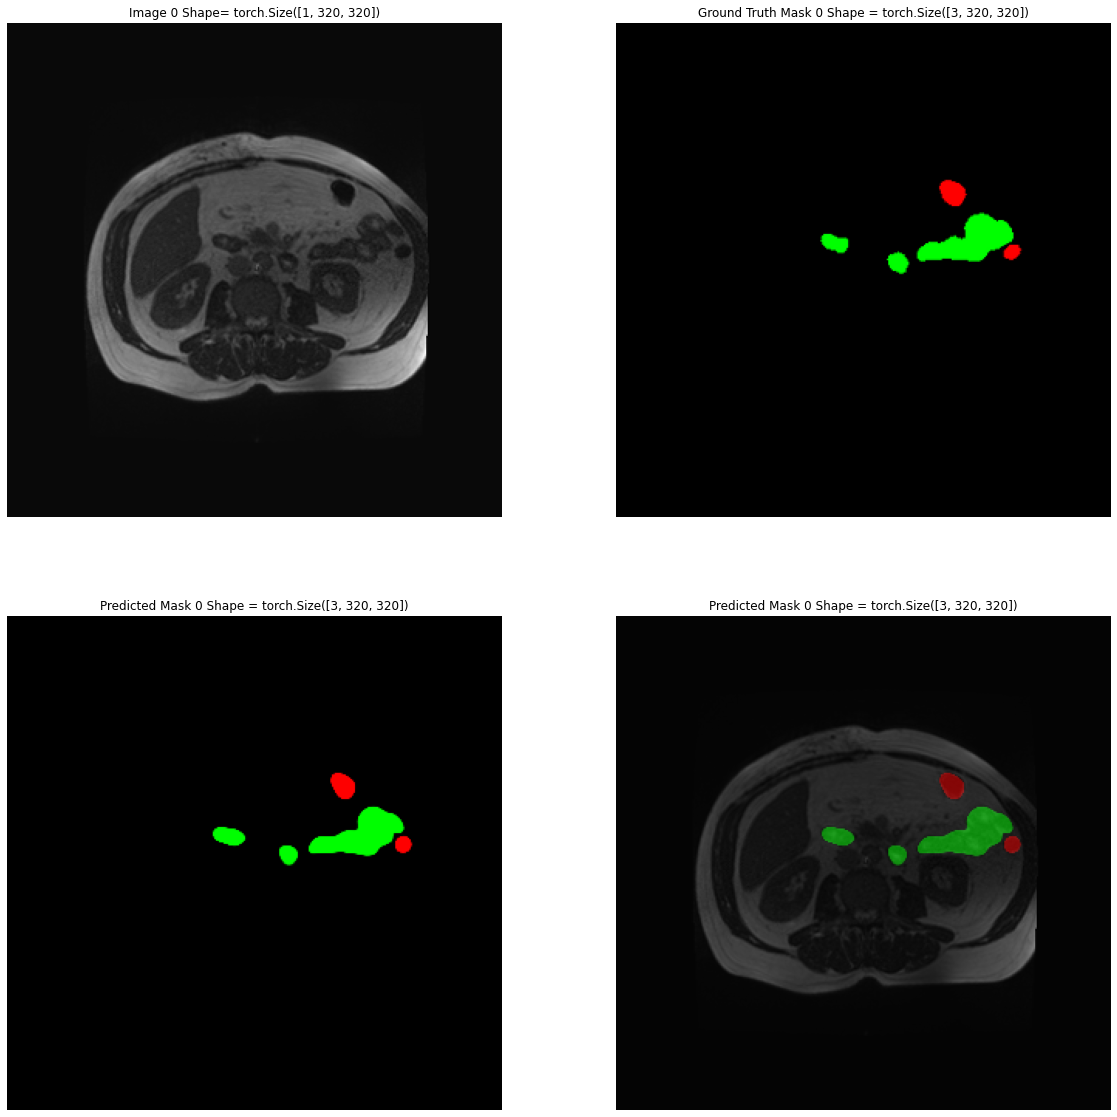

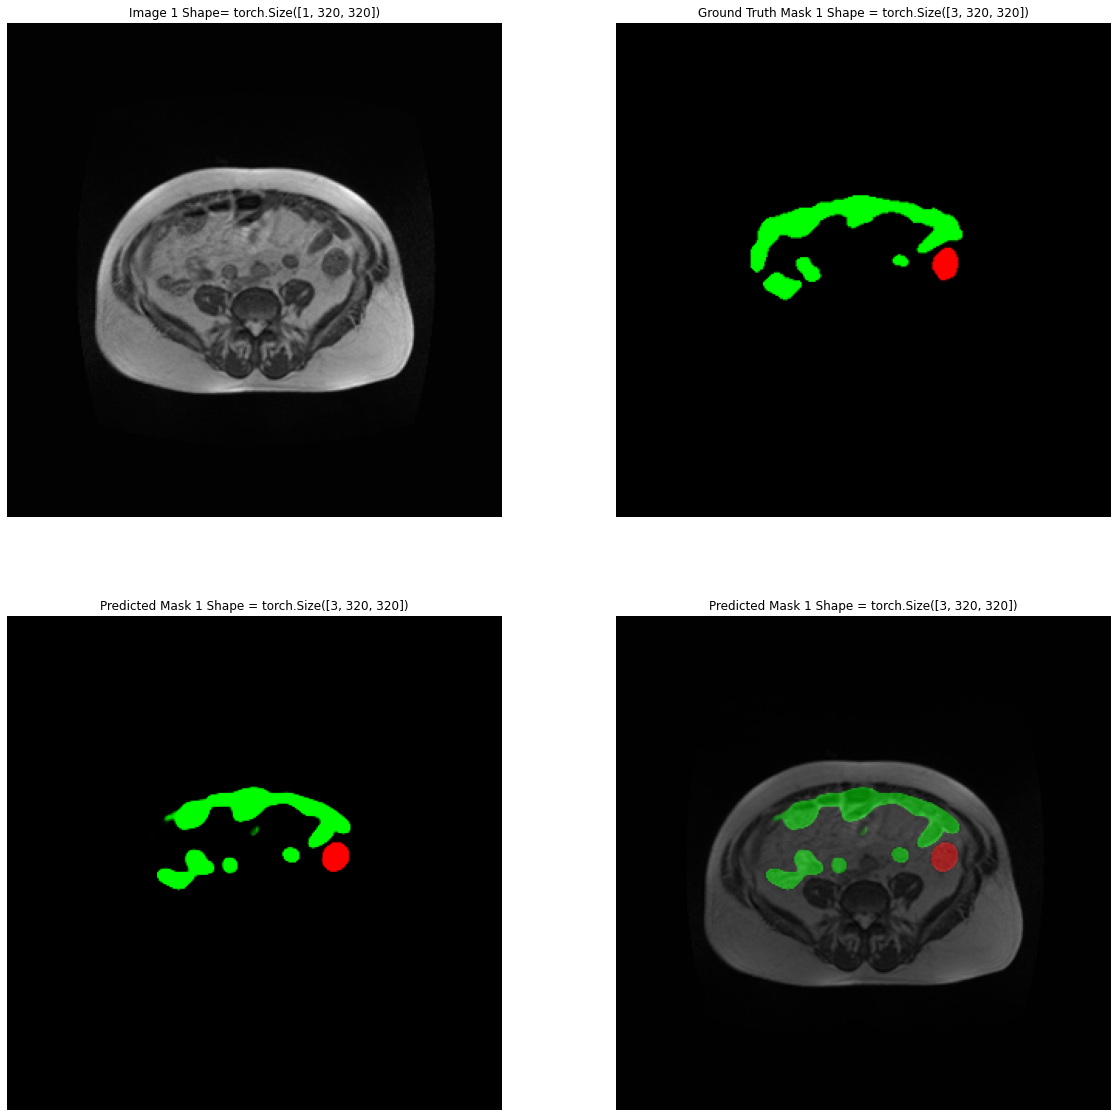

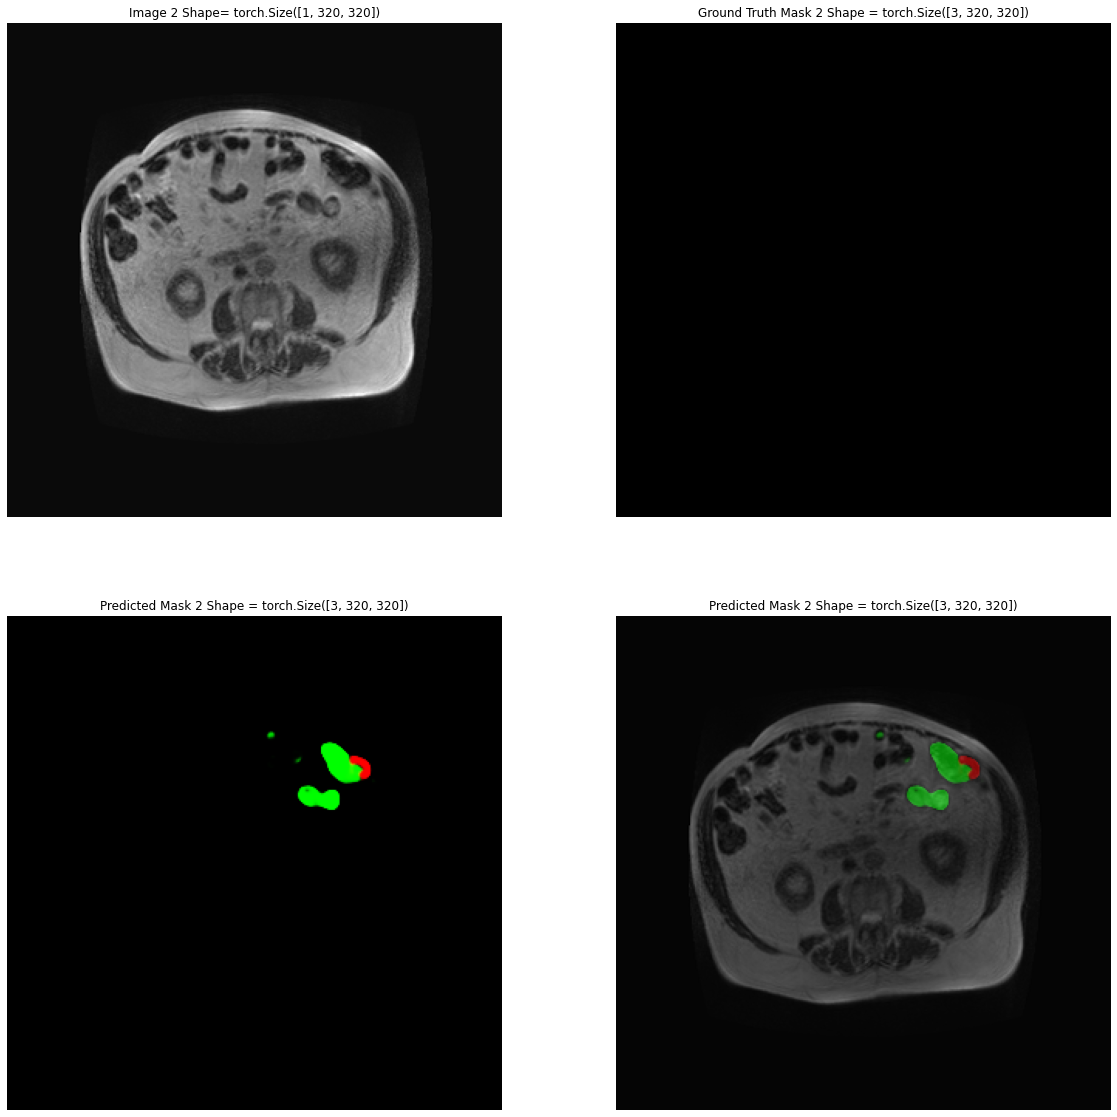

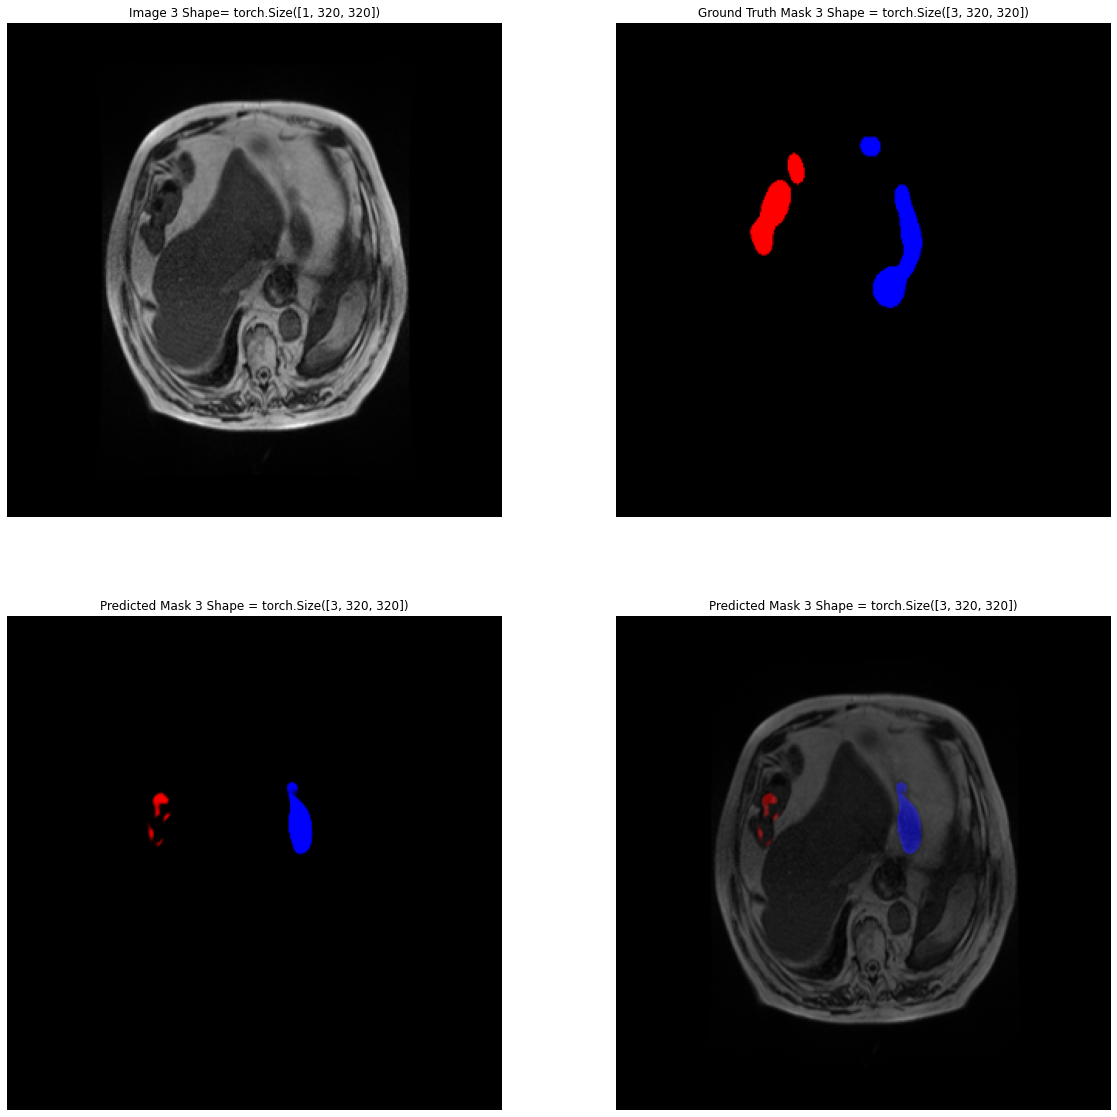

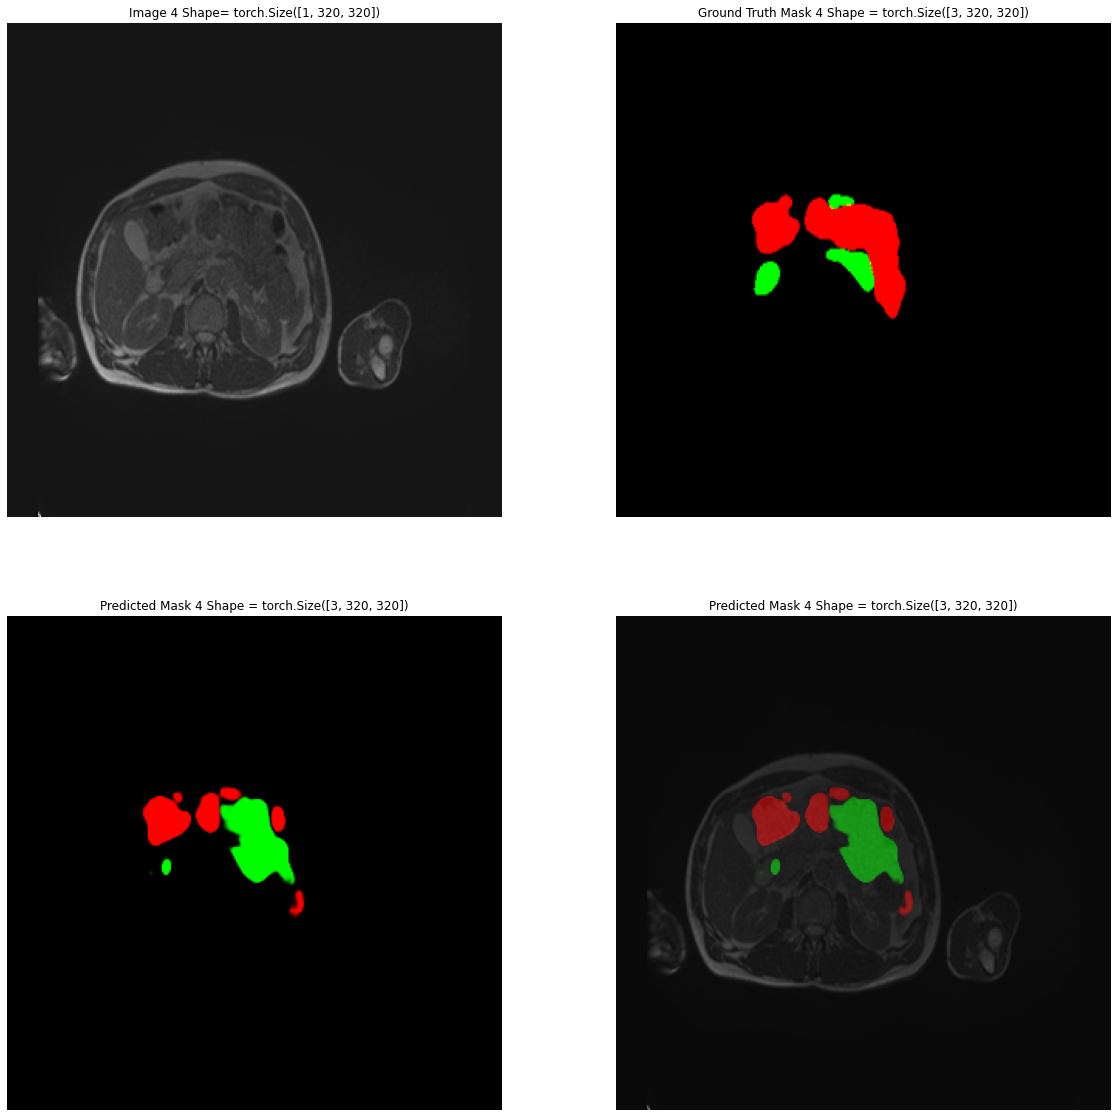

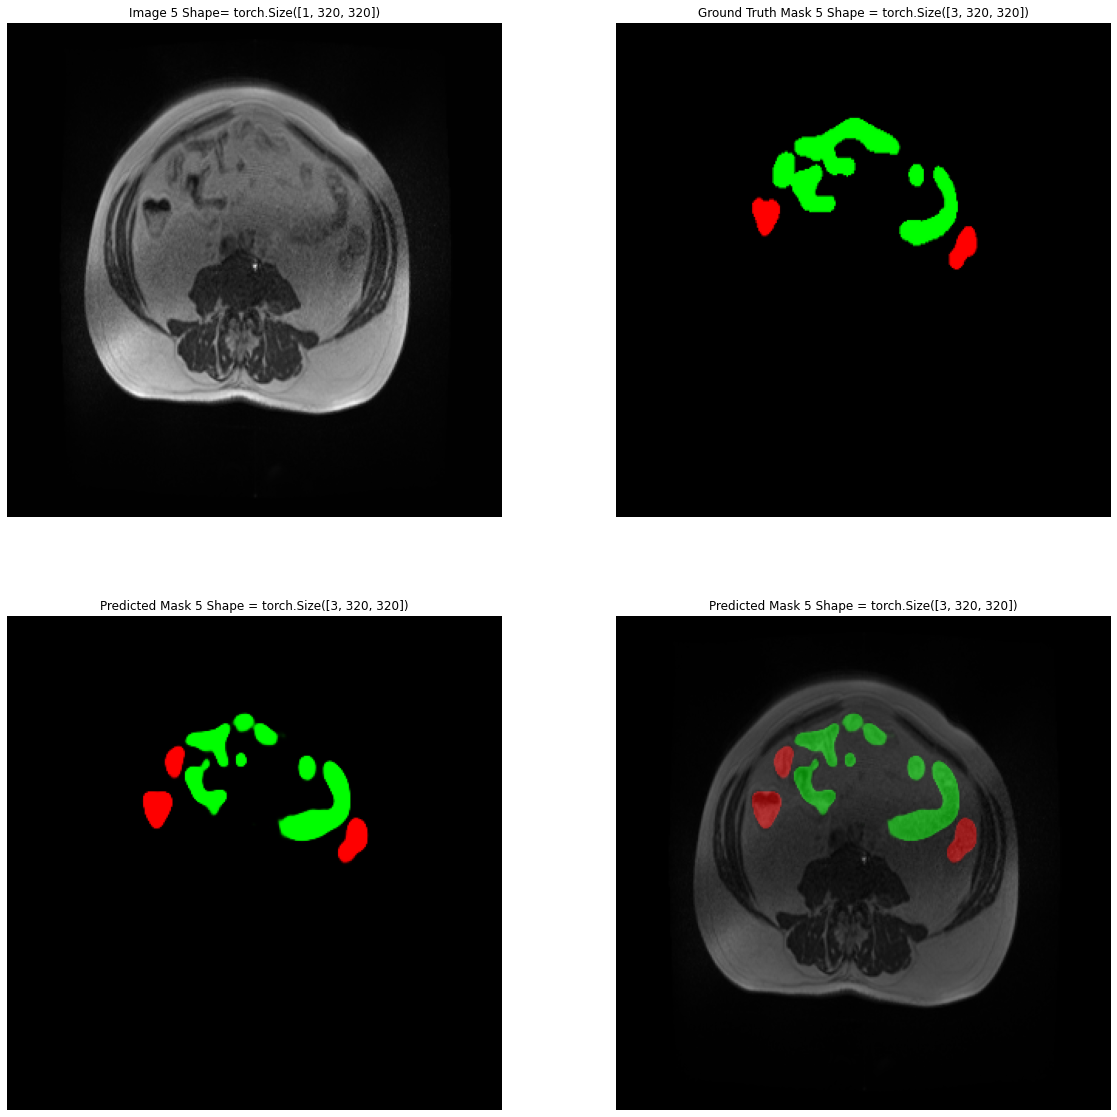

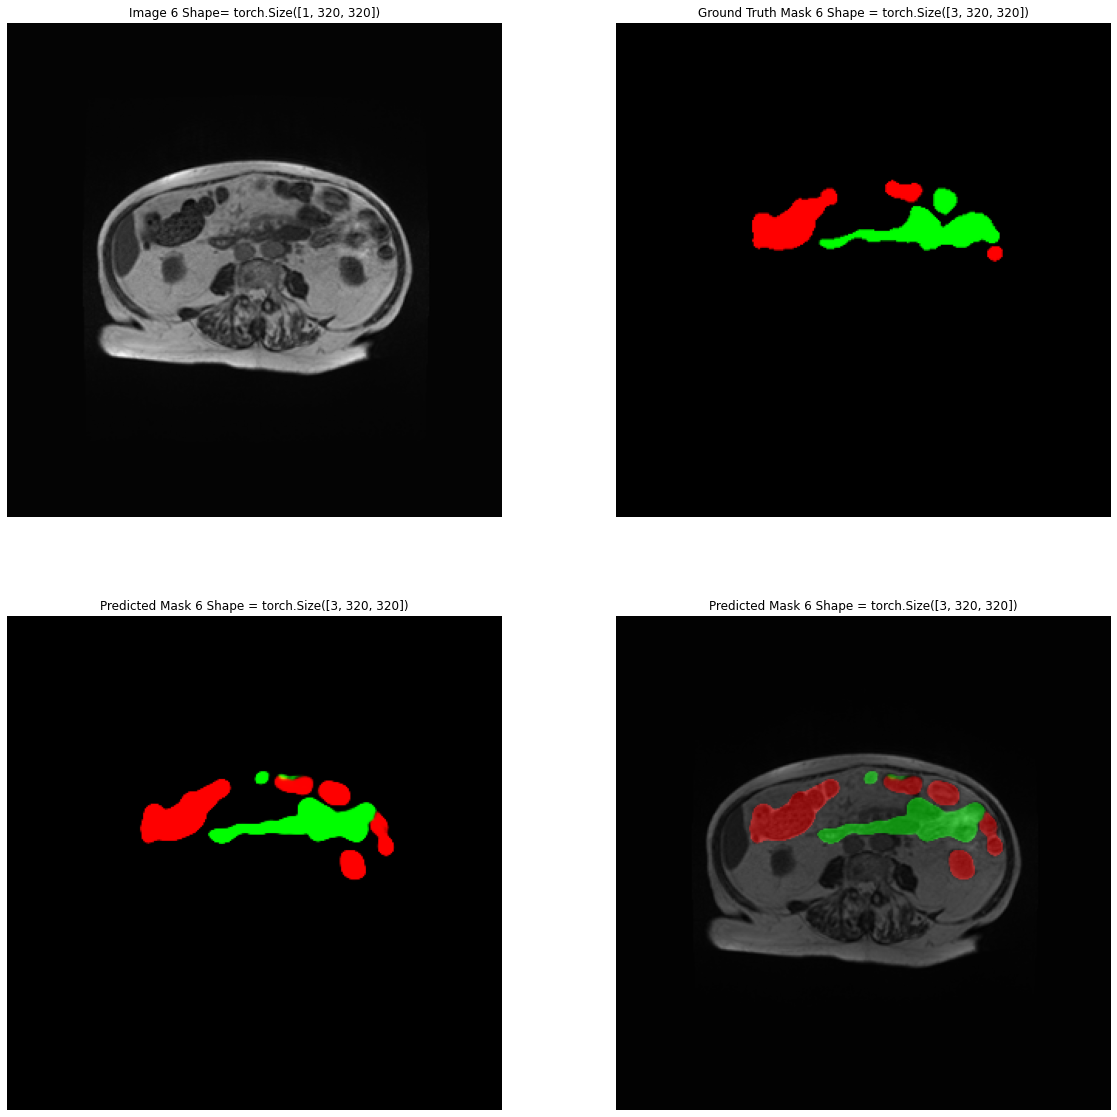

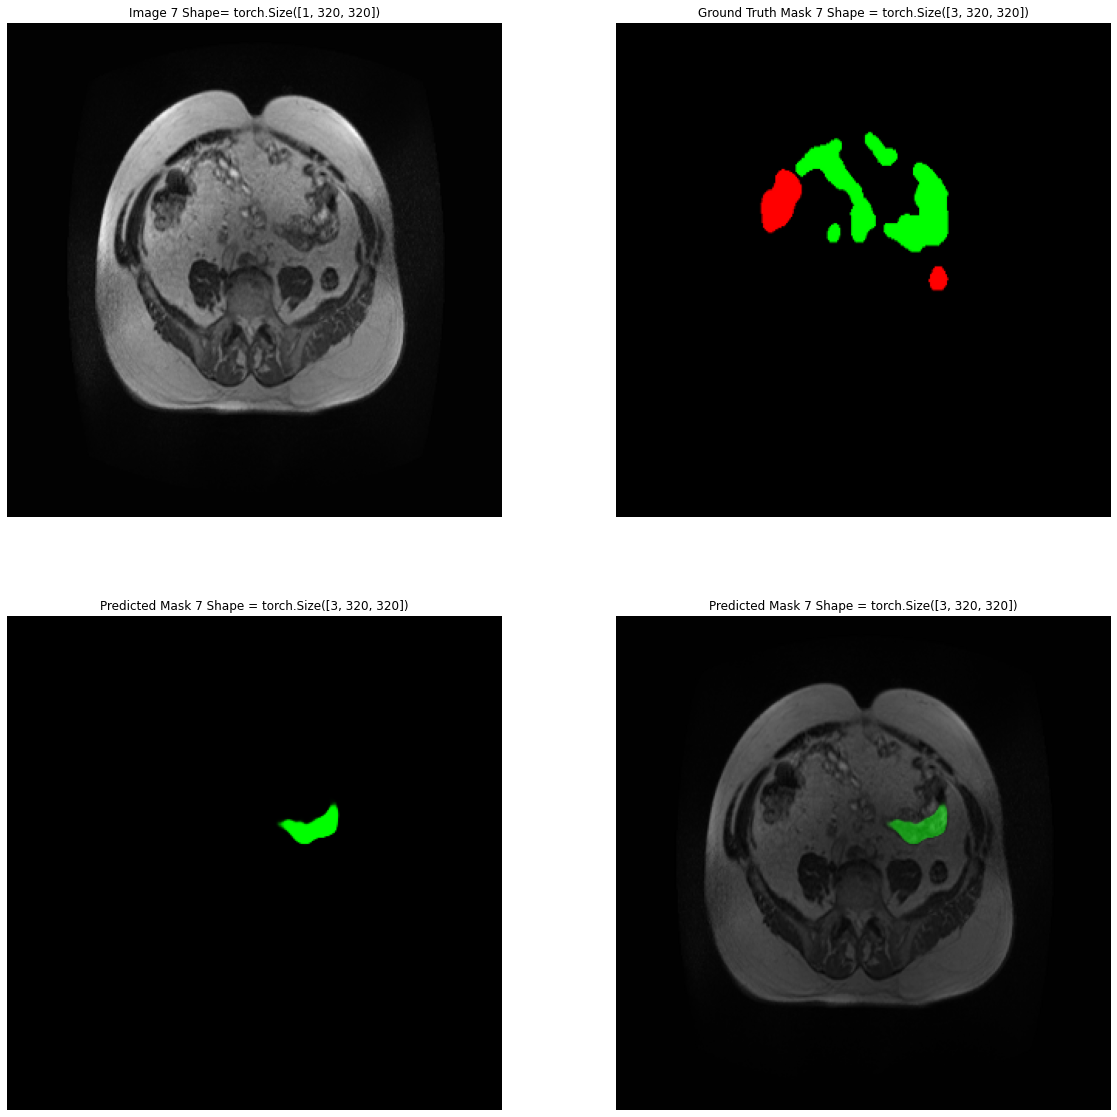

In [39]:
for idx in range(0,8):
    plot_result(data=data, output=output, idx=idx)

## Calculate the error metrics on the validation folds

In [29]:
model_name = "Unet-3-2.pth"
loss_fn = criterion
metric_fn = dice_coef
n_folds = int(df2d['fold'].max()) + 1

In [30]:

mean_metric = 0

for fold in range(0,n_folds):
    
    model = smp.Unet(
    encoder_name="efficientnet-b0",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=3)                    # model output channels (number of classes in your dataset)
    
    model_in_str = MODEL_FOLDER/("fold-" + str(fold) + '-' + model_name) 
    print(model_in_str)
    model.load_state_dict(torch.load(model_in_str))
    model.to(torch.device(DEVICE))
    model.eval()

    train_dataset, valid_dataset = prepare_datasets(df2d, fold, train_transforms, scale_transforms)
    

    valid_dataloader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                                   batch_size=8,
                                                   num_workers=10,
                                                   pin_memory=True,
                                                   shuffle=True)
    
    

        
    validation_loss, validation_metric = validatefp32(valid_dataloader,
                                                      loss_fn,
                                                      metric_fn,
                                                      model)



    print('Fold-{}- Loss: {:.4f}, Metric = {:.3f}'.format(fold, validation_loss, validation_metric))
    
    mean_metric = mean_metric + validation_metric
    
print("Mean metric =",mean_metric/n_folds)    

/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-0-Unet-3-2.pth


  0%|          | 0/1108 [00:00<?, ?it/s]

Fold-0- Loss: 0.1404, Metric = 0.877
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-1-Unet-3-2.pth


  0%|          | 0/1112 [00:00<?, ?it/s]

Fold-1- Loss: 0.1315, Metric = 0.883
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-2-Unet-3-2.pth


  0%|          | 0/810 [00:00<?, ?it/s]

Fold-2- Loss: 0.1582, Metric = 0.869
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-3-Unet-3-2.pth


  0%|          | 0/896 [00:00<?, ?it/s]

Fold-3- Loss: 0.1032, Metric = 0.908
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-4-Unet-3-2.pth


  0%|          | 0/886 [00:00<?, ?it/s]

Fold-4- Loss: 0.1451, Metric = 0.884
Mean metric = tensor(0.8843, device='cuda:0')


In [26]:
torch.cuda.empty_cache()